**Table of contents**<a id='toc0_'></a>    
- [Initial Tests with OFC](#toc1_)    
  - [Plotting PSD](#toc1_1_)    
  - [Getting FlatComb](#toc1_2_)    
- [Neural Network Training - PyTorch](#toc2_)    
  - [Datasets](#toc2_1_)    
    - [Add FlatCombs](#toc2_1_1_)    
  - [Forward Network](#toc2_2_)    
    - [Test Phase](#toc2_2_1_)    
  - [Inverse Network](#toc2_3_)    
    - [Test Phase](#toc2_3_1_)    
  - [Inverse Network - PINN](#toc2_4_)    
    - [Test phase](#toc2_4_1_)    
- [Bayesian Optimization](#toc3_)    
  - [Forward Network](#toc3_1_)    
  - [Inverse Network](#toc3_2_)    
  - [Inverse Network - PINN](#toc3_3_)    
- [Other Auxiliar Figures](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
# TODO: adicionar duas variáveis de número de picos, 
# número de pontos a serem extraídos do comb na geração 
# do dataset e número de pontos a serem usados no treinamento
# n_collected_peaks = 101 # Number of peaks to be collected from the comb in the generation of the dataset
# n_training_peaks = 11 # Number of peaks to be used in the training

# TODO: na comparação mostrar não apenas 11 picos (n_training_peaks) mas também alguns picos laterais

# TODO: Verificar se não faz mais sentido:
#  - treinar a rede com zero_mean = False e adicionar variável de potência do sinal no treinamento
#  - retirar variáveis de fase dos moduladores
#  - duplicar frequência no último sinal de controle?

# TODO: Replicar resultados do artigo:
#  - Usar gerador com DDMZM para gerar 100k amostras uniformemente distribuídas
#  - Usar variáveis: P, V1, V2, Vbias1, Vbias2 (não usar variáveis de fase) 
#  - V1 e V2: (−5∼5V), Vbias1 e Vbias2: (−15∼15V), P: (−10 ∼ 10 dBm)
#  - 9 picos
#  - Vpi: 
#  - Rs: 10 Gb/s


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
from ofc_functions import *
from nn_functions import *
import os, glob

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device} mãe")

Runnning in cuda mãe


In [3]:
# Parameters for the OFC signal
ofc_args = parameters()

ofc_args.SpS = 64            # Samples per symbol. Determines the window size
ofc_args.Rs  = 10e9          # Symbol rate (baud rate - symbols per second)
ofc_args.Ts  = 1/ofc_args.Rs          # Symbol period (s)
ofc_args.Fa  = 1/(ofc_args.Ts/ofc_args.SpS)    # Sampling frequency of the signal (samples per second)
ofc_args.Ta  = 1/ofc_args.Fa          # Sampling period of the signal (s)
ofc_args.NFFT = ofc_args.SpS      # Number of points of the FFT (multiple of SpS) 
ofc_args.t = torch.arange(0, ofc_args.SpS*10).to(device)*ofc_args.Ta # Time vector for the signal (s)
ofc_args.Vpi = 2             # Voltage required to achieve a π phase shift (V)
#ofc_args.Vpi_IM = 5.5             # Voltage required to achieve a π phase shift (V)
#ofc_args.Vpi_PM = 3.5            # Voltage required to achieve a π phase shift (V)

ofc_args.P = 1              # Amplitude of the laser optical field
ofc_args.n_peaks = 11       # Number of peaks to be found in the signal

# Parameters for the modulators cascaded
mod_args = parameters()
mod_args.V_min = 0 # Minimum amplitude voltage (V)
mod_args.V_max = 3 # Maximum amplitude voltage (V)
mod_args.Phase_min = 0 # Minimum phase (rad)
mod_args.Phase_max = 2*torch.pi # Maximum phase (rad) --> Phase is periodic with period 2*π
#mod_args.Phase_max = 10*2*torch.pi # Maximum phase (rad)
mod_args.Vb_min = 0 # Minimum bias voltage (V)
mod_args.Vb_max = 4*ofc_args.Vpi # Maximum bias voltage (V) --> Vb is periodic with period 4*Vπ
#args.Vb_max = 10*4*args.Vpi # Maximum bias voltage (V)
mod_args.bounds = [(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max), 
        (mod_args.Phase_min, mod_args.Phase_max),(mod_args.Phase_min, mod_args.Phase_max), (mod_args.Phase_min, mod_args.Phase_max),
        (mod_args.Vb_min,mod_args.Vb_max), (mod_args.Vb_min,mod_args.Vb_max)] # Bounds of the parameters

#mod_args.bounds = [(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max), 
#        (mod_args.Phase_min, mod_args.Phase_max),(mod_args.Phase_min, mod_args.Phase_max), (mod_args.Phase_min, mod_args.Phase_max),
#        (mod_args.Vb_min,mod_args.Vb_max)] # Bounds of the parameters

freqs_peaks_GHz = torch.linspace(-(ofc_args.n_peaks//2),ofc_args.n_peaks//2,ofc_args.n_peaks) # Frequency range in GHz for n_peaks


# <a id='toc1_'></a>[Initial Tests with OFC](#toc0_)

## <a id='toc1_1_'></a>[Plotting PSD](#toc0_)

In [ ]:
def plot_signalPower_and_frequencyComb(V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3):
    
    params = V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3
    params = torch.tensor(params).unsqueeze(0).to(device)

    frequencyComb = frequencyCombGenerator_MZM_MZM_PM(params, ofc_args.Rs, ofc_args.t, ofc_args.P, ofc_args.Vpi)
    #frequencyComb = frequencyCombGenerator_PM_PM_MZM(params, ofc_args.Rs, ofc_args.t, ofc_args.P, ofc_args.Vpi)
    #frequencyComb = frequencyCombGenerator_DDMZM(params, ofc_args.Rs, ofc_args.t, ofc_args.P, ofc_args.Vpi)

    _, ax = plt.subplots(2,2,figsize = (10,6))

    power = torch.abs(frequencyComb.squeeze().cpu())**2
    ax[0,0].plot(ofc_args.t.squeeze().cpu()[:ofc_args.SpS*4]*1e9, power[:ofc_args.SpS*4], label = "Optical Signal")
    ax[0,0].set_xlabel("Time (ns)")
    ax[0,0].set_ylabel("Power (W)")
    ax[0,0].set_xlim(0,4*ofc_args.Ts*1e9)
    ax[0,0].set_ylim(0,1)
    ax[0,0].legend(loc='upper right')
    ax[0,0].grid()

    phase = np.unwrap(torch.angle(frequencyComb.squeeze()).cpu())
    ax[0,1].plot(ofc_args.t.squeeze().cpu()[:ofc_args.SpS*4]*1e9, phase[:ofc_args.SpS*4], label = "Optical Signal")
    ax[0,1].set_xlabel("Time (ns)")
    ax[0,1].set_ylabel("Phase (rad)")
    ax[0,1].set_xlim(0,4*ofc_args.Ts*1e9)
    ax[0,1].set_ylim(-5*torch.pi,5*torch.pi)
    ax[0,1].legend(loc='upper right')
    ax[0,1].grid()
    
    Pxx, freqs = get_psd_ByFFT(frequencyComb, ofc_args.Fa, ofc_args.NFFT)
    log_Pxx = 10*torch.log10(Pxx)
    peaks, indx = get_indx_peaks(log_Pxx, ofc_args.NFFT/ofc_args.SpS, ofc_args.n_peaks)

    ax[1,0].plot(freqs.squeeze().cpu()/ofc_args.Rs, log_Pxx.squeeze().cpu(), label = "Optical Signal Spectrum")
    ax[1,0].plot(freqs[indx].squeeze().cpu()/ofc_args.Rs, peaks.squeeze().cpu(), 'o')
    ax[1,0].set_xlim(-15,15)
    ax[1,0].set_ylim(-200,-50)
    ax[1,0].legend(loc='lower right');
    ax[1,0].set_xlabel("Frequency (GHz) - Normalized to symbol rate");
    ax[1,0].set_ylabel("Power (dB/Hz)")
    ax[1,0].grid()
    
    mean = torch.mean(peaks.squeeze()).cpu().numpy()
    var = torch.var(peaks.squeeze()).cpu().numpy()

    x_array = np.array([freqs.squeeze().cpu().numpy()[0],freqs[-1].squeeze().cpu().numpy()])/ofc_args.Rs
    ax[1,0].plot(x_array, np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1,0].plot(x_array, np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1,0].plot(x_array, np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")

    ax[1,1].axis('off')
    ax[1,1].text(0, 0.7, "Mean: %.2f dB" %mean, fontsize=10)
    ax[1,1].text(0, 0.6, "Standard Deviation: %.2f dB" %np.sqrt(var), fontsize=10)
    ax[1,1].text(0, 0.4, "Variance: %.4f dB^2"%var, fontsize=12)
    ax[1,1].text(0, 0.3, "max - min: %.4f dB" %(torch.max(peaks.squeeze().cpu()) - torch.min(peaks.squeeze().cpu())), fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
import ipywidgets as widgets

initial_values = [ 2.39532993e+00,  2.14083606e+00,  1.74865649e+00,  3.09513887e+00, 3.09518252e+00,  3.09526099e+00,  3.00775498e+00, -1.11022302e-20]

V1     = widgets.FloatSlider(value=initial_values[0], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V1')
V2     = widgets.FloatSlider(value=initial_values[1], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V2')
V3     = widgets.FloatSlider(value=initial_values[2], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V3')
Phase1 = widgets.FloatSlider(value=initial_values[3], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase1')
Phase2 = widgets.FloatSlider(value=initial_values[4], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase2')
Phase3 = widgets.FloatSlider(value=initial_values[5], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase3')
Vb2    = widgets.FloatSlider(value=initial_values[6], min=mod_args.Vb_min,    max=mod_args.Vb_max,   step = 0.001, description = 'Vb2')
Vb3    = widgets.FloatSlider(value=initial_values[7], min=mod_args.Vb_min,    max=mod_args.Vb_max,   step = 0.001, description = 'Vb3')

ui1 = widgets.HBox([V1, V2, V3, Vb2])
ui2 = widgets.HBox([Phase1, Phase2, Phase3, Vb3])
out1 = widgets.interactive_output(plot_signalPower_and_frequencyComb, {'V1': V1, 'V2': V2,'V3':V3,'Phase1':Phase1, 'Phase2':Phase2, 'Phase3':Phase3,'Vb2': Vb2, 'Vb3': Vb3})

display(ui1, ui2, out1)

## <a id='toc1_2_'></a>[Getting FlatComb](#toc0_)

In [ ]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [1.5, 1.5, 1.5, np.pi, np.pi, np.pi, 3, 0]
#initial_guess = [2.7894168, 2.6391733, 0.7795948, 3.1160705, 3.2805085, 3.265839,  6.7473345, 0]

ofc_args.t = np.arange(0, ofc_args.SpS*10, dtype=np.float64)*ofc_args.Ta # Time vector for the signal (s)
optimized_params,_, _ = optimization_flatComb_numpy(initial_guess, args = ofc_args, bounds = mod_args.bounds)
ofc_args.t = torch.arange(0, ofc_args.SpS*10).to(device)*ofc_args.Ta # Time vector for the signal (s)

V1, V2, V3, Phase1, Phase2, Phase3, Vb2, Vb3 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.4f} V")
print(f"V2: {V2:.4f} V")
print(f"V3: {V3:.4f} V")
print(f"Phase1: {Phase1:.4f} rad")
print(f"Phase2: {Phase2:.4f} rad")
print(f"Phase3: {Phase3:.4f} rad")
print(f"Vb2: {Vb2:.4f} V")
print(f"Vb3: {Vb3:.4f} V")

In [ ]:
ofc_args.t = torch.tensor(ofc_args.t, device = device, dtype = torch.float32)
plot_signalPower_and_frequencyComb(*optimized_params)


# <a id='toc2_'></a>[Neural Network Training - PyTorch](#toc0_)

## <a id='toc2_1_'></a>[Datasets](#toc0_)

In [5]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

n_samples = 250000

if train_ratio + val_ratio + test_ratio > 1:
    raise ValueError("The sum of the ratios must be less than or equal to 1")

In [15]:
#load datasets if they exist, create them otherwise
datasets_folder = "saved_data/datasets/"
gen = "mzm_mzm_pm_"
zero_mean = False
dataset_name = gen + f"{n_samples*1e-3:.0f}k_samples_{zero_mean}ZeroMean"
dataset_filename = datasets_folder + dataset_name + ".pt"

if os.path.exists(dataset_filename):
    print("Loading dataset...")
    dataset = torch.load(dataset_filename, weights_only=False)
    dataset.input_tensors = dataset.input_tensors.to(device)
    dataset.output_tensors = dataset.output_tensors.to(device)
    print("Datasets loaded!")
else:
    print("Creating dataset...")
    dataset = FrequencyCombDataset(frequencyCombPeaks, n_samples, ofc_args, mod_args.bounds, device = device, zero_mean=zero_mean)
    print("Datasets created!")
    torch.save(dataset, dataset_filename)
    print("Dataset saved!")


Creating dataset...
Datasets created!
Dataset saved!


### <a id='toc2_1_1_'></a>[Add FlatCombs](#toc0_)

In [16]:
files = glob.glob(datasets_folder + gen + 'flatComb_*')
if len(files) > 0:
    print("Loading flatComb datasets...")
    flatComb_inputs0_1dB = np.load(glob.glob(datasets_folder + gen + "flatComb_inputs0_1dB_*")[0])
    flatComb_outputs0_1dB = np.load(glob.glob(datasets_folder + gen + "flatComb_outputs0_1dB_*")[0])

    flatComb_inputs1_5dB = np.load(glob.glob(datasets_folder + gen + "flatComb_inputs1_5dB_*")[0])
    flatComb_outputs1_5dB = np.load(glob.glob(datasets_folder + gen + "flatComb_outputs1_5dB_*")[0])

    for file in files:
        print(file) 
    print("FlatComb datasets loaded!")

else:
    max_flat_samples = 2000

    print("Creating flatComb datasets...")
    
    ofc_args.t = np.arange(0, ofc_args.SpS*10, dtype=np.float64)*ofc_args.Ta # Time vector as numpy array for the signal (s)
    flatComb_inputs0_1dB, flatComb_outputs0_1dB, flatComb_inputs1_5dB, flatComb_outputs1_5dB = create_flatCombs_numpy(max_flat_samples, args = ofc_args, bounds = mod_args.bounds)
    ofc_args.t = torch.arange(0, ofc_args.SpS*10).to(device)*ofc_args.Ta # Time vector as torch tensor for the signal (s)

    #save flatComb_inputs and flatComb_outputs
    np.save(datasets_folder + gen + f"flatComb_inputs0_1dB_{len(flatComb_inputs0_1dB)}.npy", flatComb_inputs0_1dB)
    np.save(datasets_folder + gen + f"flatComb_outputs0_1dB_{len(flatComb_outputs0_1dB)}.npy", flatComb_outputs0_1dB)

    np.save(datasets_folder + gen + f"flatComb_inputs1_5dB_{len(flatComb_inputs1_5dB)}.npy", flatComb_inputs1_5dB)
    np.save(datasets_folder + gen + f"flatComb_outputs1_5dB_{len(flatComb_outputs1_5dB)}.npy", flatComb_outputs1_5dB)

    print("FlatComb datasets created and saved!")

Loading flatComb datasets...
saved_data/datasets\mzm_mzm_pm_flatComb_inputs0_1dB_11147.npy
saved_data/datasets\mzm_mzm_pm_flatComb_inputs1_5dB_6567.npy
saved_data/datasets\mzm_mzm_pm_flatComb_outputs0_1dB_11147.npy
saved_data/datasets\mzm_mzm_pm_flatComb_outputs1_5dB_6567.npy
FlatComb datasets loaded!


In [17]:
p0_1 = 0.04 #percentage of flatComb0_1 desired in the dataset
p1_5 = 0.02 #percentage of flatComb1_5 desired in the dataset

flat_nsamples0_1 = int(p0_1*n_samples/(1 - p0_1 - p1_5))
flat_nsamples1_5 = int(p1_5*n_samples/(1 - p1_5 - p0_1))

flat_nsamples_idx0_1 = np.arange(flat_nsamples0_1)
flat_nsamples_idx1_5 = np.arange(flat_nsamples1_5)
flatComb_0_1dB_dataset = FrequencyCombDataset(flatComb_inputs0_1dB[flat_nsamples_idx0_1], flatComb_outputs0_1dB[flat_nsamples_idx0_1], device = device, norm_scales=dataset.norm_scales, zero_mean=dataset.zero_mean)
flatComb_1_5dB_dataset = FrequencyCombDataset(flatComb_inputs1_5dB[flat_nsamples_idx1_5], flatComb_outputs1_5dB[flat_nsamples_idx1_5], device = device, norm_scales=dataset.norm_scales, zero_mean=dataset.zero_mean)

In [9]:
dataset.concat_with(flatComb_0_1dB_dataset, flatComb_1_5dB_dataset, recalc_norm_scales = True)

In [10]:
#split the dataset
train_dataset, val_dataset, test_dataset = dataset.split_dataset([train_ratio, val_ratio, test_ratio], shuffle = True)

In [ ]:
# Create data loaders
batch_size = 1000
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

flat_loader = DataLoader(flatComb_0_1dB_dataset, batch_size = batch_size, shuffle=True)

In [11]:
#pencentage of flatcombs

count01 = 0
count15 = 0

for i in range(len(dataset)):
    min_val = dataset.denormalize(torch.min(dataset.output_tensors[i]))
    max_val = dataset.denormalize(torch.max(dataset.output_tensors[i]))
    if max_val - min_val < 1.0:
        count01 += 1
    elif max_val - min_val < 5.0:
        count15 += 1
print(f"Percentage of flatcombs0_1 in train dataset: {count01/len(dataset)*100:.2f}%")
print(f"Percentage of flatcombs1_5 in train dataset: {count15/len(dataset)*100:.2f}%")

Percentage of flatcombs0_1 in train dataset: 4.00%
Percentage of flatcombs1_5 in train dataset: 2.11%


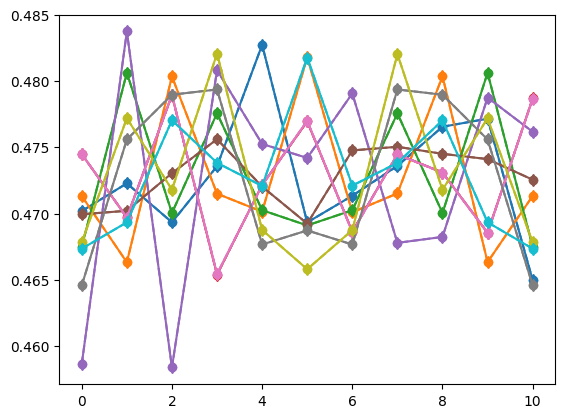

In [13]:
#verifing if frequencyCombPeaks can generate the same frequencyComb as the dataset

inputs = flatComb_1_5dB_dataset.input_tensors[0:10]
targets = flatComb_1_5dB_dataset.output_tensors[0:10]

outputs = frequencyCombPeaks(inputs, ofc_args)
outputs = outputs - torch.mean(outputs, dim=1).unsqueeze(1)
outputs = flatComb_1_5dB_dataset.normalize(outputs)

for i in range(10):
    plt.plot(outputs[i].cpu().numpy(), "d-", color = f"C{i}")
    plt.plot(targets[i].cpu().numpy(), "o--", color = f"C{i}")

## <a id='toc2_2_'></a>[Forward Network](#toc0_)

In [ ]:
# Create data loaders
batch_size = 80
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

flat_loader = DataLoader(flatComb_0_1dB_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
# Initialize the model
n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]
architecture = [n_inputs, 176, 176, 176, 176, 176, 176, 176, 176, n_outputs]

forward_net = FrequencyCombNet(architecture).to(device)
forward_net_name = "model_" + "_".join([f"{n:.0f}" for n in architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"
forward_net_path = "saved_data/models/"+ forward_net_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
for_optimizer = torch.optim.Adam(forward_net.parameters(), lr = 8.5e-5) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(forward_net_path):
    print("Loading model...")
    checkpoint = torch.load(forward_net_path, map_location=torch.device(device))
    forward_net.load_state_dict(checkpoint['model_state_dict'])
    for_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

In [ ]:
#architecture = [8, 296, 296, 296, 296, 296, 296, 11]
calc_num_params(architecture)

In [ ]:
## losses
for_losses_path = "saved_data/losses/" + forward_net_name + '_losses.npz'

# Load training losses if file exists
if os.path.exists(for_losses_path):
    losses = np.load(for_losses_path)
    train_losses = list(losses['train_losses'])
    val_losses = list(losses['val_losses'])
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

val_loss_min = 1

In [ ]:

num_epochs = 1000
val_loss_min = 1

PATIENCE = 100
patience_counter = 0
for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, _, _ = run_one_epoch_forward("train", train_loader, forward_net, criterion, device, for_optimizer)
    train_losses.append(avg_train_loss) #Epoch training losses for plotting

    # Validation phase
    avg_val_loss, _, _ = run_one_epoch_forward("val", val_loader, forward_net, criterion, device)
    val_losses.append(avg_val_loss) # Append average validation loss for the epoch

    # Save model if validation loss has decreased; Early stopping
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save({"model_state_dict" : forward_net.state_dict(),
            "optimizer_state_dict": for_optimizer.state_dict()}, 
            "saved_data/models/min_loss/"+ forward_net_name + "val_min.pth")
        val_loss_min = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch} with validation loss: {avg_val_loss:.6f}')
            break

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")



In [ ]:
# Save model
torch.save({"model_state_dict" : forward_net.state_dict(),
            "optimizer_state_dict": for_optimizer.state_dict()}, forward_net_path)

# Save training and validation losses for the inverse model
np.savez(for_losses_path, train_losses = np.array(train_losses), val_losses = np.array(val_losses))


In [ ]:
#load min_loss model
checkpoint = torch.load("saved_data/models/min_loss/"+ forward_net_name + "val_min.pth", map_location=torch.device(device))
forward_net.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
train_array = convert_to_real_loss(train_losses, train_dataset.norm_scales)
val_array = convert_to_real_loss(val_losses, train_dataset.norm_scales)
figname = "figures/" + forward_net_name + "_training_progress.png"
plot_training_progress_style(train_array, val_array, title = "", ylabel = r"$Erro\; (dB/Hz)^2$", ylim=(0,10), average_curves = False, M = 10, figname=figname)

### <a id='toc2_2_1_'></a>[Test Phase](#toc0_)

In [ ]:
# Flat Test phase

avg_test_loss, outputs, targets = run_one_epoch_forward("test", flat_loader, forward_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

for i in range(min(10, outputs.shape[0])):  # Loop over the first n examples

    # Denormalize
    outputs_denorm = train_dataset.denormalize(outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    real_loss = criterion(outputs_denorm, targets_denorm).item()

    # Plot the comparison
    title = ''
    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    outputs_denorm = outputs_denorm.cpu().detach().numpy().squeeze()

    figname = "figures/forward/" + f"forward_flat_sample_{i+1}.png"
    
    plot_comparison_style(targets_denorm, outputs_denorm, freqs_peaks_GHz, real_loss, figname, title, ylim = (-3,3), show_max_min=True)


In [ ]:
# Test phase
avg_test_loss, outputs, targets = run_one_epoch_forward("test", test_loader, forward_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

for i in range(min(10, outputs.shape[0])):  # Loop over the first n examples

    # Denormalize
    outputs_denorm = train_dataset.denormalize(outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    real_loss = criterion(outputs_denorm, targets_denorm).item()

    # Plot the comparison
    title = ''
    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    outputs_denorm = outputs_denorm.cpu().detach().numpy().squeeze()

    figname = "figures/forward/" + f"forward_sample_{i+1}.png"
    
    plot_comparison_style(targets_denorm, outputs_denorm, freqs_peaks_GHz, real_loss, figname, title, ylim = (-30,30))


## <a id='toc2_3_'></a>[Inverse Network](#toc0_)

In [ ]:
# Create data loaders
batch_size = 80
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

In [ ]:
# Load the pre-trained forward model
forward_net_name = 'model_8_176_176_176_176_176_176_176_176_11_mzm_mzm_pm_250k_samples_batch_size_80'
forward_net_path = "saved_data/models/" + forward_net_name + ".pth"

model_dict_data = torch.load(forward_net_path, map_location=torch.device(device))
forward_architecture = get_architecture(model_dict_data)
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(model_dict_data["model_state_dict"])  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

# Create an inverse model
inverse_architecture = [n_outputs, 345, 345, 345, 345, 345,345, n_inputs]
inverse_net = FrequencyCombNet(inverse_architecture).to(device)
inverse_net_name = "model_inv_for_" + "_".join([f"{n:.0f}" for n in inverse_architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"+ "inverse_net"
inverse_net_path = "saved_data/models/"+ inverse_net_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = 7.97e-5) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(inverse_net_path):
    print("Loading model...")
    checkpoint = torch.load(inverse_net_path, map_location=torch.device(device))
    inverse_net.load_state_dict(checkpoint['model_state_dict'])
    inv_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(inverse_net_name)
    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

In [ ]:

calc_num_params(inverse_architecture)

In [ ]:
## losses
inv_losses_path = "saved_data/losses/" + inverse_net_name + '_losses.npz'

# Load training losses if file exists
if os.path.exists(inv_losses_path):
    losses = np.load(inv_losses_path)
    train_losses = list(losses['train_losses'])
    val_losses = list(losses['val_losses'])
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

val_loss_min = 1

In [ ]:
flat_val_losses = []
min_test_loss = 0.5

In [ ]:
num_epochs = 500

PATIENCE = 200
patience_counter = 0

for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, _, _, _, _ = run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)
    train_losses.append(avg_train_loss)

    # Validation phase
    avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
    val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Save model if validation loss has decreased; Early stopping
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, 
            "saved_data/models/min_loss/"+ inverse_net_name + "val_min.pth")
        val_loss_min = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch} with validation loss: {avg_val_loss:.6f}')
            break

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")


    # Test FlatComb
    perfect_flat_comb = torch.tensor([-90]*n_outputs).unsqueeze(0).to(device)
    perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype=torch.float32)
    perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

    perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

    inverse_peaks = torch.tensor(frequencyCombPeaks(perfect_flat_comb_inv_output, ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    inv_loss = criterion(perfect_flat_comb, inverse_peaks).item()
    inv_loss = convert_to_real_loss(inv_loss, train_dataset.norm_scales).item()

    flat_val_losses.append(inv_loss)  # Append average validation loss for the epoch

    if inv_loss < min_test_loss:
        min_test_loss = inv_loss
        print(f"Epoch: {epoch}/{num_epochs}... Test loss: {inv_loss:.6f} (dB/Hz)^2 .. validation loss: {avg_val_loss:.6f}")
        torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, 
            "saved_data/models/min_loss/"+ inverse_net_name + "_min_flat_loss.pth")
        
    if inv_loss < 0.1:
        print(f"Epoch: {epoch}/{num_epochs}... Test loss: {inv_loss:.6f} (dB/Hz)^2 .. validation loss: {avg_val_loss:.6f}")

        #break


In [ ]:
plt.plot(flat_val_losses[10:])
plt.ylim(0,2)
#plt.xlim(460,470)

In [ ]:
# Save model
torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, inverse_net_path)

# Save training and validation losses for the inverse model
np.savez(inv_losses_path, train_losses = np.array(train_losses), val_losses = np.array(val_losses))

In [ ]:
#load min flat loss model
checkpoint = torch.load("saved_data/models/min_loss/" + inverse_net_name + "_min_flat_loss.pth", map_location=torch.device(device))
inverse_net.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
#load the min loss
checkpoint = torch.load("saved_data/models/min_loss/" + inverse_net_name + "val_min.pth", map_location=torch.device(device))
inverse_net.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
train_array = convert_to_real_loss(train_losses, train_dataset.norm_scales)
val_array = convert_to_real_loss(val_losses, train_dataset.norm_scales)
figname = "figures/inv_forward/" + inverse_net_name + "_training_progress.png"

plot_training_progress_style(train_array, val_array, title = "",  average_curves = False, figname = figname, ylim=(0,10))

### <a id='toc2_3_1_'></a>[Test Phase](#toc0_)

In [ ]:
# Test phase

perfect_flat_comb = torch.tensor([-90]*n_outputs).unsqueeze(0).to(device) #flat comb
#perfect_flat_comb = torch.tensor([-80,-85,-90,-95,-100,-105,-100,-95,-90,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb = torch.tensor(0.5*np.arange(-5,6,1)**2, dtype=torch.float32).unsqueeze(0).to(device) #quadratic comb
#perfect_flat_comb = torch.tensor(200*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb 
#perfect_flat_comb = torch.tensor(-60*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb negative
#perfect_flat_comb = torch.tensor(-np.abs(8*np.arange(-5,6,1)), dtype=torch.float32).unsqueeze(0).to(device) #hate comb
#perfect_flat_comb = torch.tensor(3.6*np.arange(-5,6,1), dtype=torch.float32).unsqueeze(0).to(device) # linear comb
#perfect_flat_comb = -2.5*torch.tensor([-80,-85,-80,-85,-80,-85,-80,-85,-80,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb[0,5]= -115 #hole

perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype=torch.float32)*dataset.zero_mean
perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

inverse_peaks = torch.tensor(frequencyCombPeaks(perfect_flat_comb_inv_output, ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
inverse_peaks = train_dataset.normalize(inverse_peaks)

loss = criterion(perfect_flat_comb, inverse_peaks).item()
real_loss = convert_to_real_loss(loss, train_dataset.norm_scales).item()

perfect_flat_comb_denorm = train_dataset.denormalize(perfect_flat_comb).cpu().detach().numpy().squeeze()
inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks).cpu().detach().numpy().squeeze()

# Plot the Comparison
title = ''
figname = 'figures/fig_inverse_hat_comb'
figname = 'figures/fig_inverse_hole_comb'
figname = 'figures/inverseNet_sample3'
figname = 'figures/fig_inverse_flat_comb'
figname = 'figures/fig_inverse_linear_comb'
figname = 'figures/fig_inverse_gaussian_comb'

figname = 'figures/inv_forward/inv_forward_perfect_flat_comb.png'

plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, real_loss, figname, title, show_max_min=True, ylim = (-3,3))
#plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, real_loss, figname, title, show_max_min=False)

In [ ]:
# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", train_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

In [ ]:
# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", val_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

In [ ]:
# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", flat_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

In [ ]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", test_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

In [ ]:

# Loop over the first n examples
for i in range(min(10, targets.shape[0])):

    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_outputs[i].unsqueeze(0), ofc_args), dtype=torch.float32).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    forward_peaks = forward_net(inputs[i])
    
    # Denormalize
    inv_for_outputs_denorm = train_dataset.denormalize(inv_for_outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)
    forward_peaks_denorm = train_dataset.denormalize(forward_peaks)

    inv_for_loss = criterion(inv_for_outputs_denorm, targets_denorm).item()
    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()
    forward_loss = criterion(forward_peaks_denorm, targets_denorm).item()

    fig, ax = plt.subplots(1,1, figsize=(5,4))
    freqs_GHz = np.linspace(-(ofc_args.n_peaks//2),ofc_args.n_peaks//2,ofc_args.n_peaks) # Frequency range in GHz for n_peaks
    ax.plot(freqs_GHz,targets_denorm.cpu().detach().numpy().squeeze(),"s", label='Target',markersize=7)
    ax.plot(freqs_GHz,inv_for_outputs_denorm.cpu().detach().numpy().squeeze(),"o", label=f'Inverse-Forward Prediction')
    ax.plot(freqs_GHz,forward_peaks_denorm.cpu().detach().numpy().squeeze(),"o", label=f'Forward Prediction')
    ax.plot(freqs_GHz,inverse_peaks_denorm.cpu().detach().numpy().squeeze(),"^",label=f'Inverse Prediction')
    ax.set_xticks(freqs_GHz)
    ax.set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax.set_ylabel("Power Spectral Density (dB/Hz)")
    ax.set_ylim(-35,35)
    ax.legend(framealpha=0.5)
    ax.set_title(f'Sample {i+1}\nForward Loss: {forward_loss:.6f} (dB/Hz)^2\nInv_For Loss: {inv_for_loss:.6f} (dB/Hz)^2\nInverse Loss: {inverse_loss:.6f} (dB/Hz)^2')
    ax.grid()


In [ ]:

# Flat Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", flat_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(5, targets.shape[0])):

    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_outputs[i].unsqueeze(0), ofc_args), dtype=torch.float32).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    
    title = ''
    figname = "figures/inv_forward/" + f"inv_forward_flat_sample_{i+1}.png"

    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title, ylim = (-3,3), show_max_min=True)

In [ ]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse("test", test_loader, forward_net, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(10, targets.shape[0])):

    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_outputs[i].unsqueeze(0), ofc_args), dtype=torch.float32).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    
    title = ''
    figname = "figures/inv_forward/" + f"inv_forward_sample_{i+1}.png"

    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title)

## <a id='toc2_4_'></a>[Inverse Network - PINN](#toc0_)

-0.000099	65	0.000081	7	298

In [11]:
# Create data loaders
batch_size = 90
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
flat_loader = DataLoader(flatComb_0_1dB_dataset, batch_size = batch_size, shuffle=True)

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

In [12]:

# Create an inverse model
inverse_architecture = [n_outputs, 392, 392, 392, 392, 392, 392, 392, 392, n_inputs]
#inverse_architecture = [n_outputs, 345, 345, 345, 345, 345, 345, 345, n_inputs]

inverse_net = FrequencyCombNet(inverse_architecture).to(device)

inverse_net_name = "model_" + "_".join([f"{n:.0f}" for n in inverse_architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"+ "inverse_net"
inverse_net_path = "saved_data/models/"+ inverse_net_name +".pth"

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = 9.8e-5) # lr - learning rate

# load model and optimizer if they exist
if os.path.exists(inverse_net_path):
    print("Loading model...")
    checkpoint = torch.load(inverse_net_path, map_location=torch.device(device), weights_only=False)
    inverse_net.load_state_dict(checkpoint['model_state_dict'])
    inv_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(inverse_net_name)
    print("Model and Optimizer loaded!")
else:
    print("No checkpoint to load!")
    print("Model and Optimizer created!")

No checkpoint to load!
Model and Optimizer created!


In [13]:
## losses
inv_losses_path = "saved_data/losses/" + inverse_net_name + '_losses.npz'

# Load training losses if file exists
if os.path.exists(inv_losses_path):
    losses = np.load(inv_losses_path)
    train_losses = list(losses['train_losses'])
    val_losses = list(losses['val_losses'])
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

val_loss_min = 1


Losses files not found.
Losses files created!


Validation loss decreased (1.000000 --> 0.000517). Epoch: 1. Saving model...
Validation loss decreased (0.000517 --> 0.000418). Epoch: 2. Saving model...
Validation loss decreased (0.000418 --> 0.000364). Epoch: 3. Saving model...
Validation loss decreased (0.000364 --> 0.000362). Epoch: 4. Saving model...
Validation loss decreased (0.000362 --> 0.000343). Epoch: 5. Saving model...
Validation loss decreased (0.000343 --> 0.000330). Epoch: 7. Saving model...
Validation loss decreased (0.000330 --> 0.000329). Epoch: 8. Saving model...
Validation loss decreased (0.000329 --> 0.000292). Epoch: 9. Saving model...
Validation loss decreased (0.000292 --> 0.000277). Epoch: 13. Saving model...
Validation loss decreased (0.000277 --> 0.000273). Epoch: 14. Saving model...
Validation loss decreased (0.000273 --> 0.000254). Epoch: 15. Saving model...
Validation loss decreased (0.000254 --> 0.000245). Epoch: 17. Saving model...
Validation loss decreased (0.000245 --> 0.000241). Epoch: 21. Saving mod

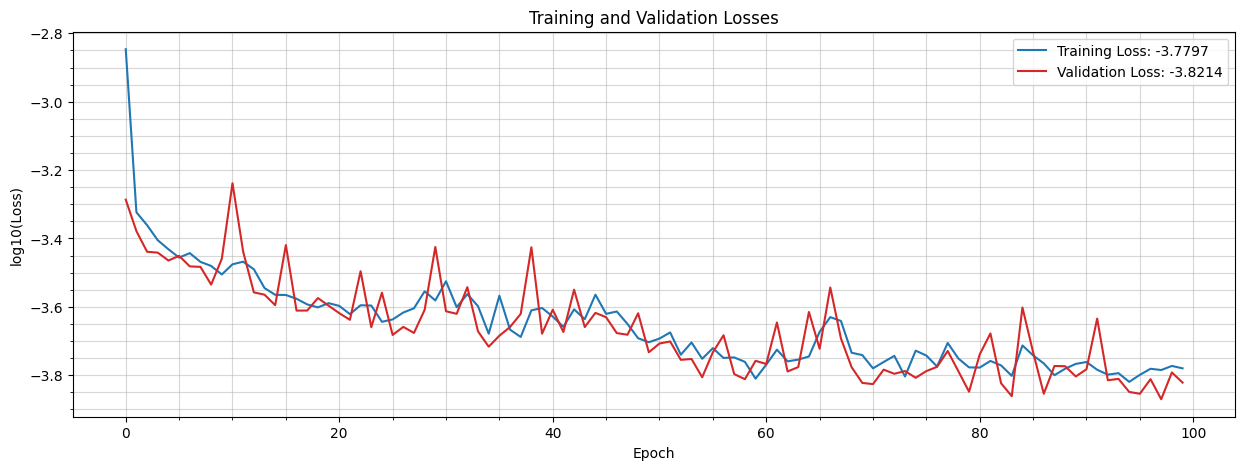

Validation loss decreased (0.000135 --> 0.000129). Epoch: 109. Saving model...
Validation loss decreased (0.000129 --> 0.000120). Epoch: 155. Saving model...
Epoch: 200/1000... Training loss: 5.675140 (dB/Hz)^2 ... Validation Loss: 6.346780 (dB/Hz)^2


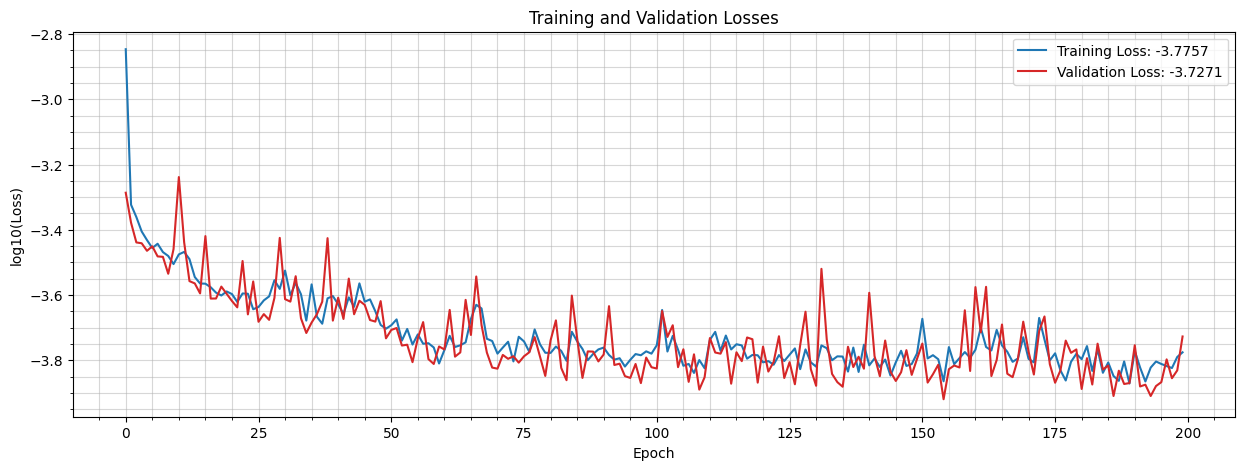

Validation loss decreased (0.000120 --> 0.000115). Epoch: 267. Saving model...
Epoch: 300/1000... Training loss: 4.982588 (dB/Hz)^2 ... Validation Loss: 4.392044 (dB/Hz)^2


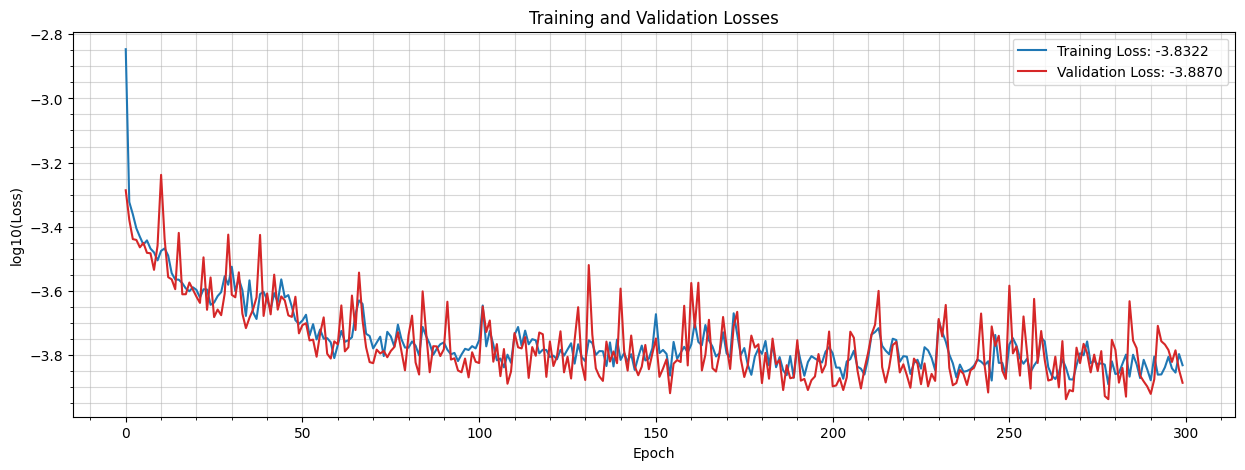

Validation loss decreased (0.000115 --> 0.000110). Epoch: 328. Saving model...
Validation loss decreased (0.000110 --> 0.000109). Epoch: 396. Saving model...
Epoch: 400/1000... Training loss: 4.301573 (dB/Hz)^2 ... Validation Loss: 4.255017 (dB/Hz)^2


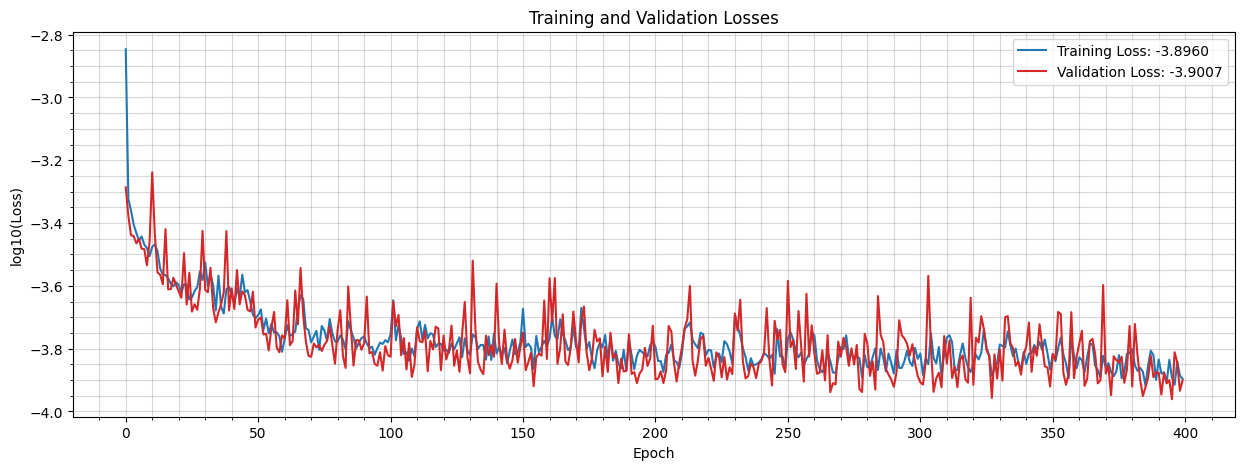

Validation loss decreased (0.000109 --> 0.000107). Epoch: 425. Saving model...
Epoch: 500/1000... Training loss: 6.011385 (dB/Hz)^2 ... Validation Loss: 4.847923 (dB/Hz)^2


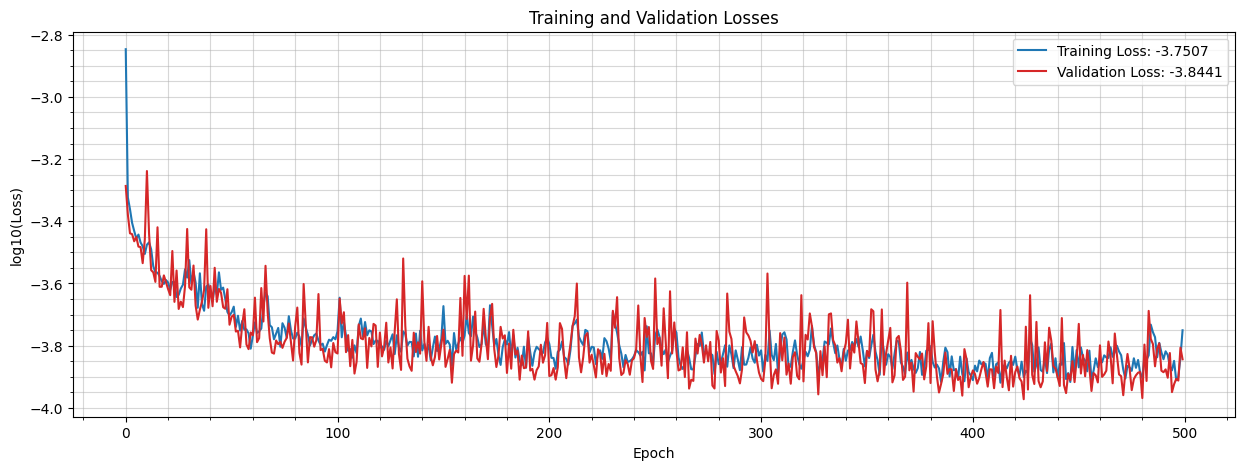

Validation loss decreased (0.000107 --> 0.000101). Epoch: 531. Saving model...
Epoch: 600/1000... Training loss: 4.104013 (dB/Hz)^2 ... Validation Loss: 3.789072 (dB/Hz)^2


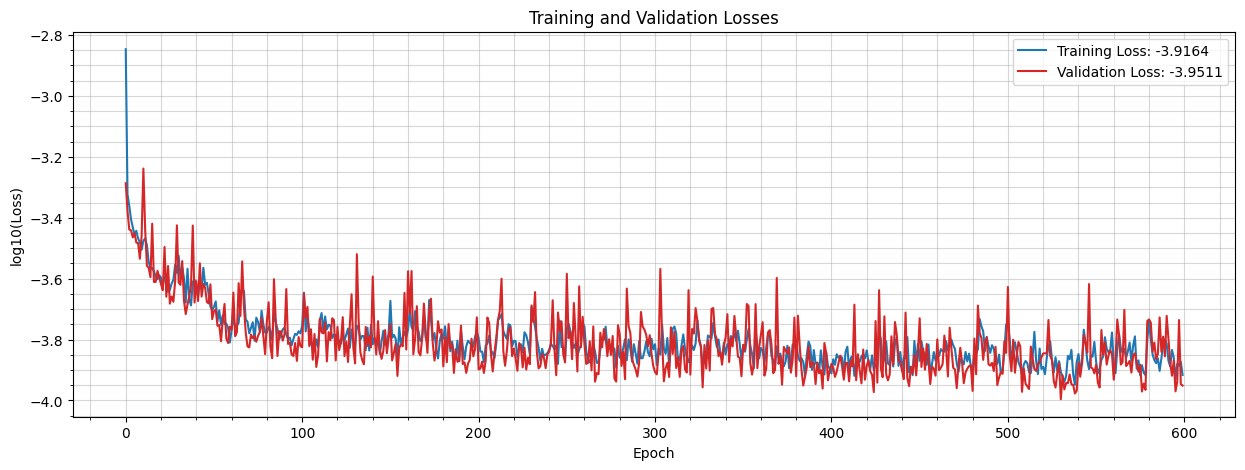

Epoch: 700/1000... Training loss: 6.407731 (dB/Hz)^2 ... Validation Loss: 5.843284 (dB/Hz)^2


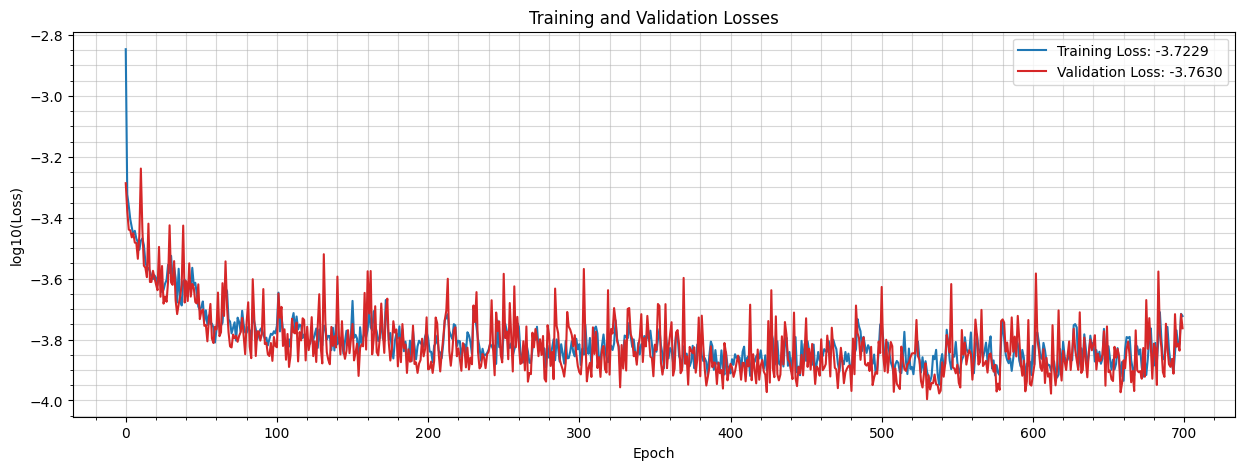

Early stopping at epoch 731 with validation loss: 0.000121


In [14]:
num_epochs = 1000

PATIENCE = 200
patience_counter = 0

for epoch in range(1, num_epochs + 1):

    # Training phase
    avg_train_loss, for_out, inv_out, tar, inp = run_one_epoch_inverse_PINN("train", train_loader, analytical_function_compact, ofc_args, inverse_net, criterion, device, inv_optimizer)
    train_losses.append(avg_train_loss)

    # Validation phase
    avg_val_loss, _, _, _, _ = run_one_epoch_inverse_PINN("val", val_loader, analytical_function_compact, ofc_args, inverse_net, criterion, device)
    val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(inverse_net.state_dict(), "saved_data/models/min_loss/"+ inverse_net_name + "val_min.pth")
        val_loss_min = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch} with validation loss: {avg_val_loss:.6f}')
            break

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")



In [29]:
# Save model
torch.save({"model_state_dict" : inverse_net.state_dict(),
            "optimizer_state_dict": inv_optimizer.state_dict()}, inverse_net_path)

# Save training and validation losses for the inverse model
np.savez(inv_losses_path, train_losses = np.array(train_losses), val_losses = np.array(val_losses))

In [19]:
#load min loss model
model_dict_data = torch.load("saved_data/models/min_loss/"+ inverse_net_name + "val_min.pth", map_location=torch.device(device), weights_only=False)
inverse_net.load_state_dict(model_dict_data)  # Load pre-trained weights

<All keys matched successfully>

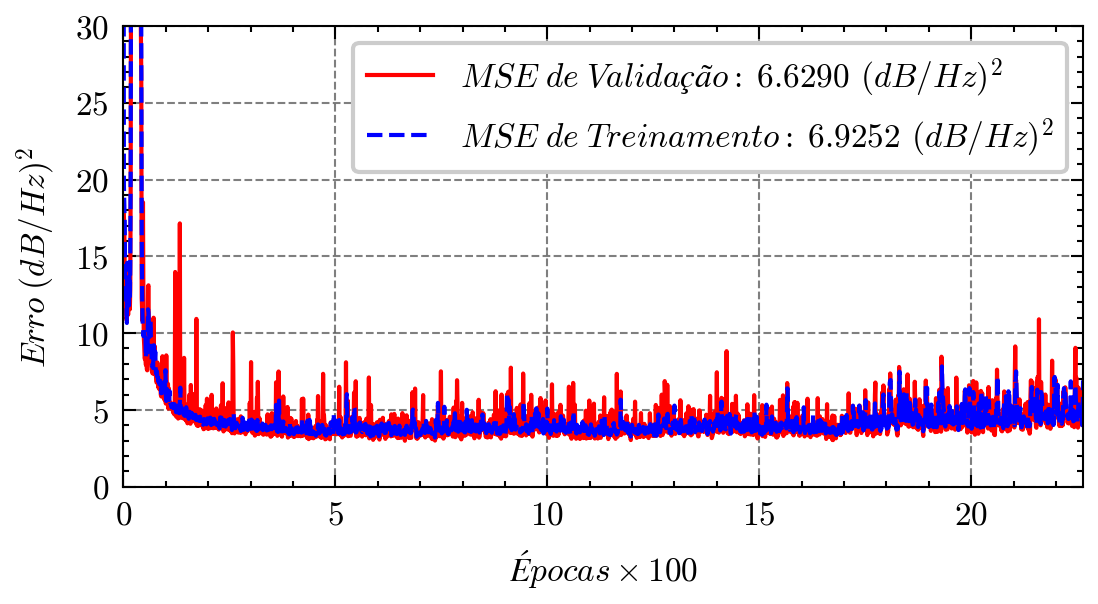

In [20]:
train_array = convert_to_real_loss(train_losses, train_dataset.norm_scales)
val_array = convert_to_real_loss(val_losses, train_dataset.norm_scales)
figname = "figures/inv_analitical/" + inverse_net_name + "_training_progress.png"

plot_training_progress_style(train_array,val_array, title = "",  average_curves = False, figname = figname, ylim = (0,30))

### <a id='toc2_4_1_'></a>[Test phase](#toc0_)

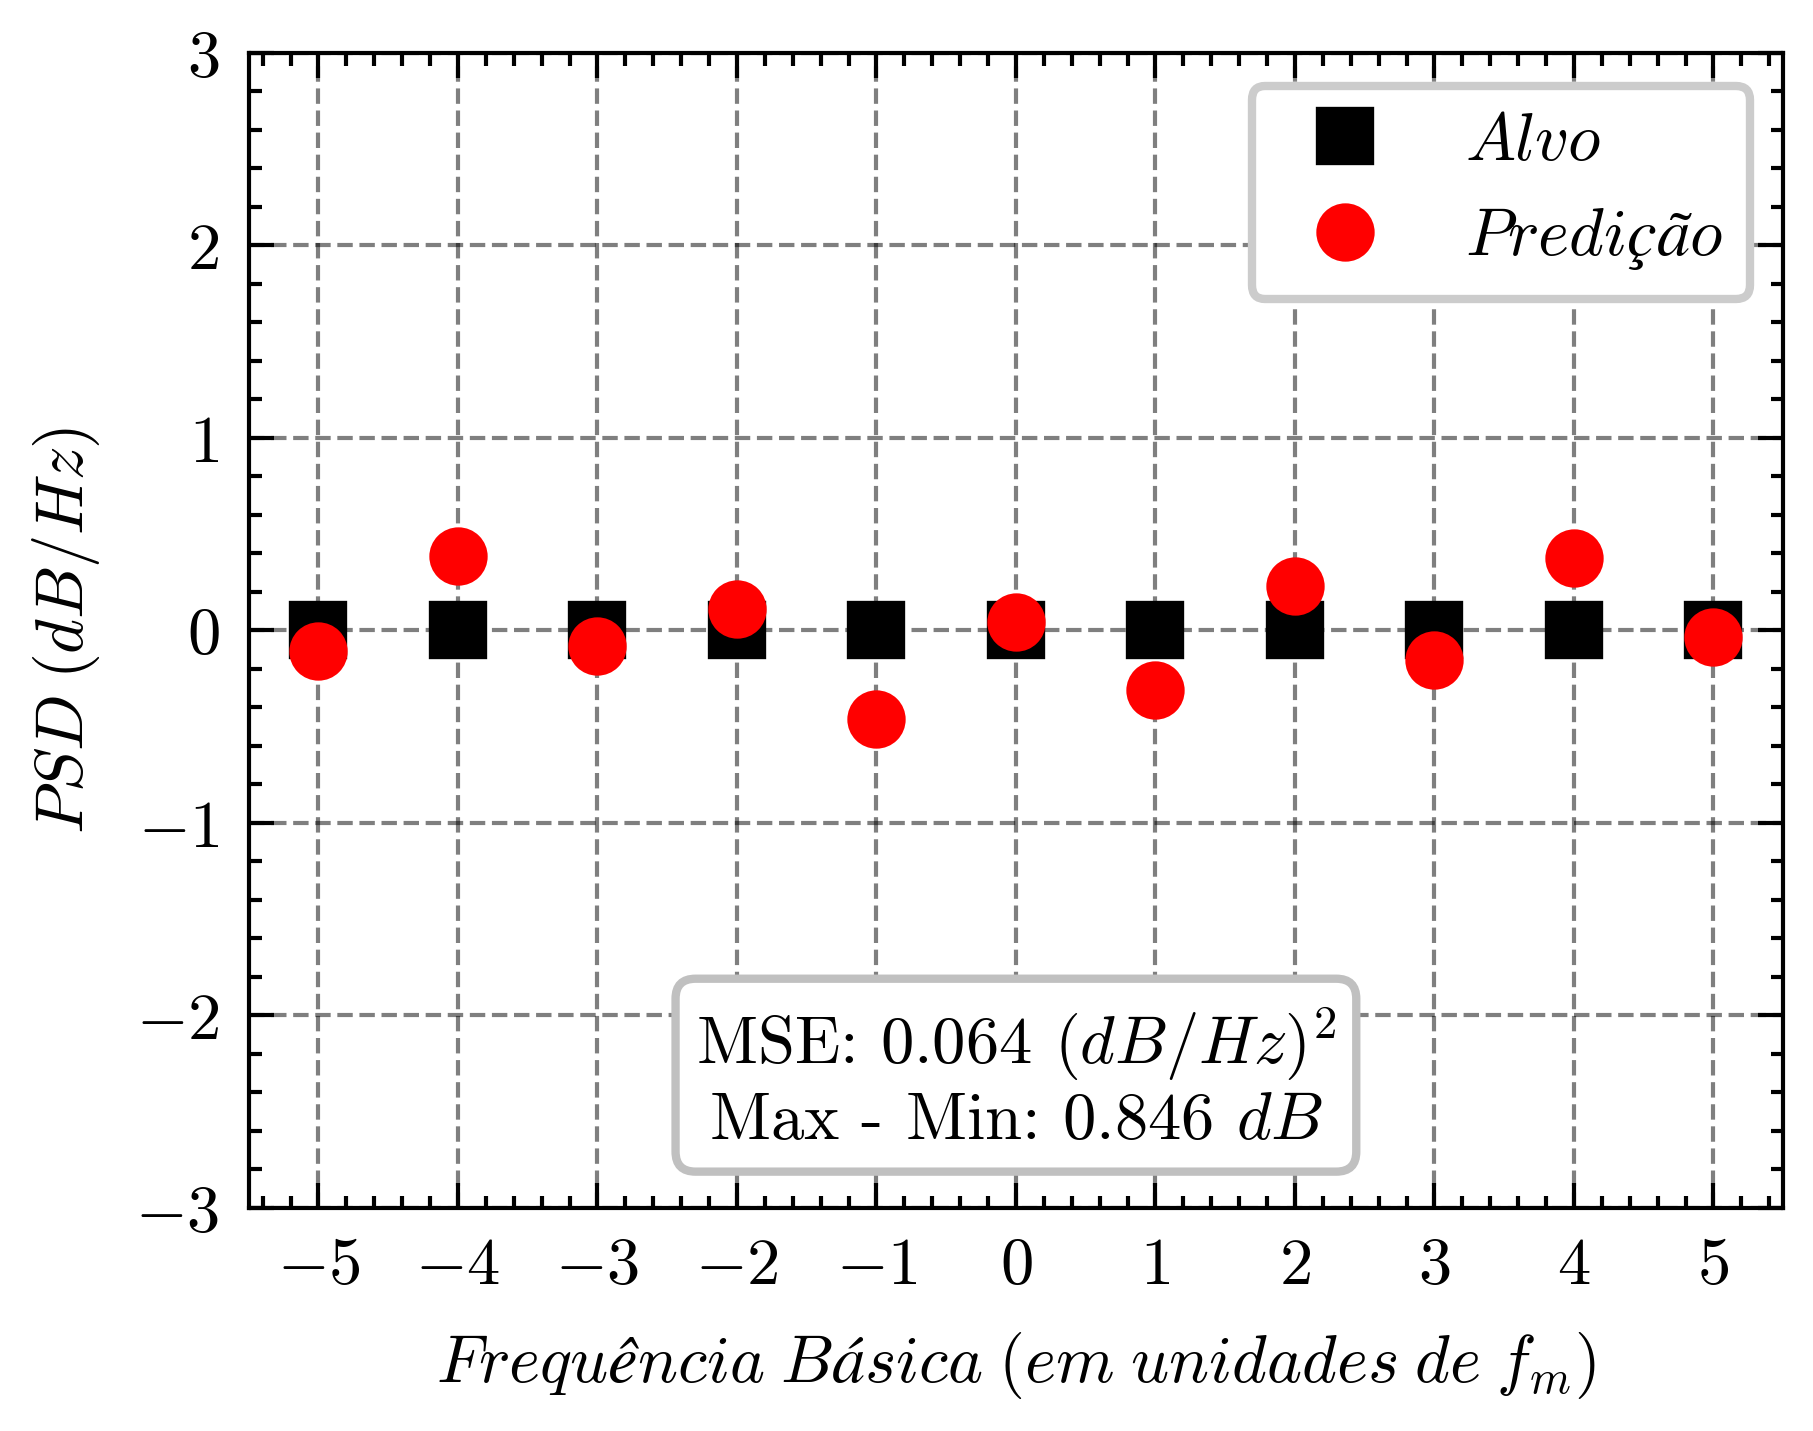

In [21]:
# Test phase

perfect_flat_comb = torch.tensor([-90]*n_outputs).unsqueeze(0).to(device) #flat comb
#perfect_flat_comb = torch.tensor([-80,-85,-90,-95,-100,-105,-100,-95,-90,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb = torch.tensor(0.5*np.arange(-5,6,1)**2, dtype=torch.float32).unsqueeze(0).to(device) #quadratic comb
#perfect_flat_comb = torch.tensor(200*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb 
#perfect_flat_comb = torch.tensor(-60*np.exp(-0.01*np.arange(-5,6,1)**2), dtype=torch.float32).unsqueeze(0).to(device) #gaussian comb negative
#perfect_flat_comb = torch.tensor(-np.abs(8*np.arange(-5,6,1)), dtype=torch.float32).unsqueeze(0).to(device) #hate comb
#perfect_flat_comb = torch.tensor(3.6*np.arange(-5,6,1), dtype=torch.float32).unsqueeze(0).to(device) # linear comb
#perfect_flat_comb = -2.5*torch.tensor([-80,-85,-80,-85,-80,-85,-80,-85,-80,-85,-80]).unsqueeze(0).to(device) #alternating comb
#perfect_flat_comb[0,5]= -115 #hole

# Test FlatComb
perfect_flat_comb = perfect_flat_comb - torch.mean(perfect_flat_comb, dtype = torch.float32) * train_loader.dataset.zero_mean
perfect_flat_comb = train_dataset.normalize(perfect_flat_comb)

perfect_flat_comb_inv_output = inverse_net(perfect_flat_comb)

inverse_peaks = frequencyCombPeaks(perfect_flat_comb_inv_output, ofc_args)
inverse_peaks = inverse_peaks - torch.mean(inverse_peaks) * train_loader.dataset.zero_mean
inverse_peaks = train_dataset.normalize(inverse_peaks)

inv_loss = criterion(perfect_flat_comb, inverse_peaks).item()
inv_loss = convert_to_real_loss(inv_loss, train_dataset.norm_scales).item()

perfect_flat_comb_denorm = train_dataset.denormalize(perfect_flat_comb).cpu().detach().numpy().squeeze()
inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks).cpu().detach().numpy().squeeze()

# Plot the Comparison
title = ''
figname = 'figures/fig_inverse_hat_comb'
figname = 'figures/fig_inverse_hole_comb'
figname = 'figures/inverseNet_sample3'
figname = 'figures/fig_inverse_flat_comb'
figname = 'figures/fig_inverse_linear_comb'
figname = 'figures/fig_inverse_gaussian_comb'
figname = 'figures/fig_inverse_flat_comb'

figname = 'figures/inv_analitical/inv_analitical_perfect_flat_comb.png'


#plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inv_loss, figname, title, show_max_min=False)
plot_comparison_style(perfect_flat_comb_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inv_loss, figname, title, show_max_min=True, ylim = (-3,3))

Test Loss: 0.053495 (dB/Hz)^2


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


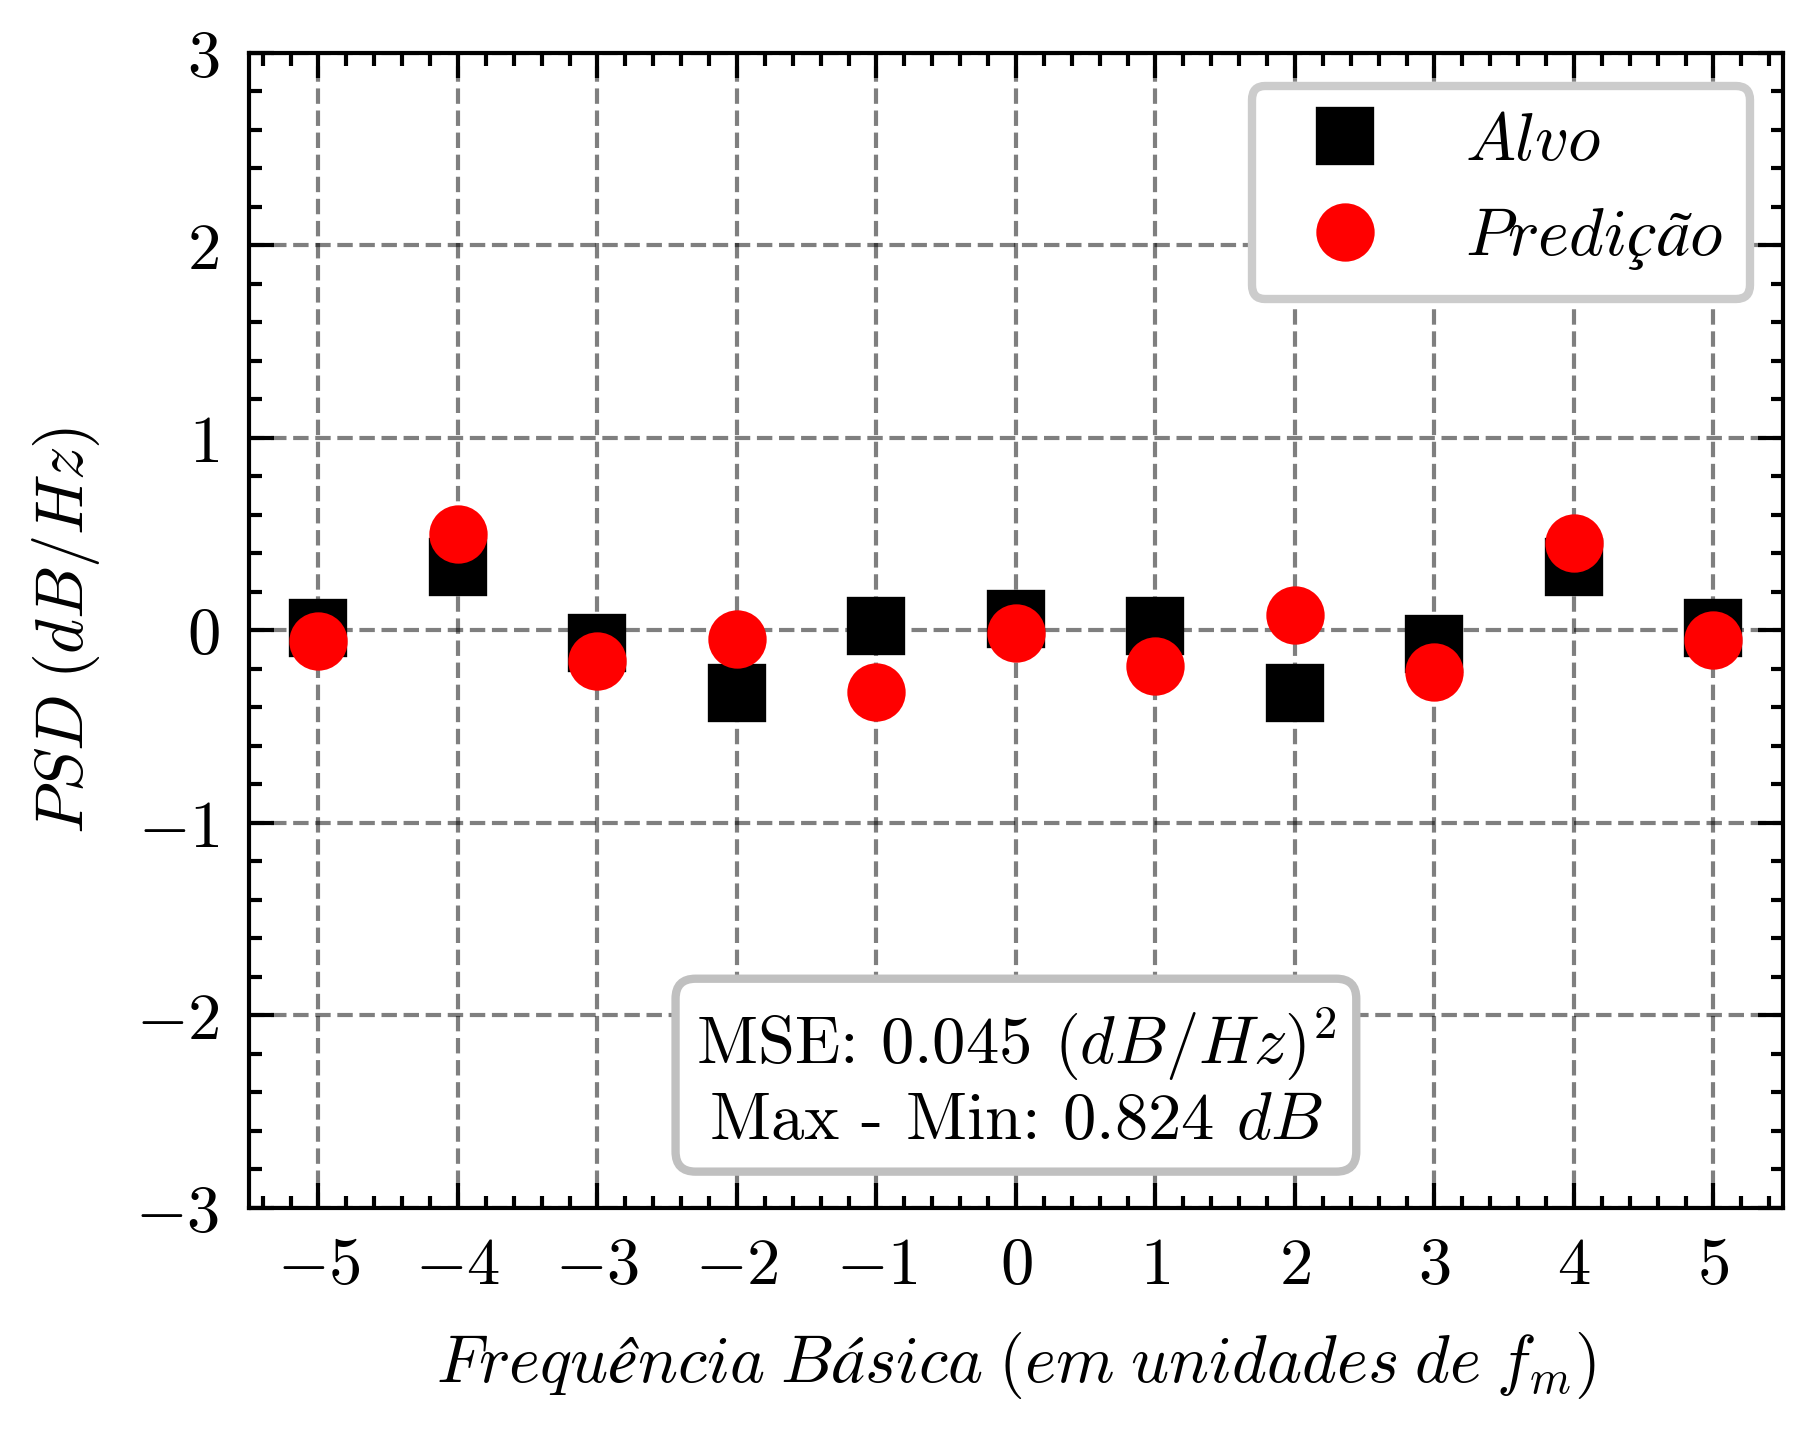

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


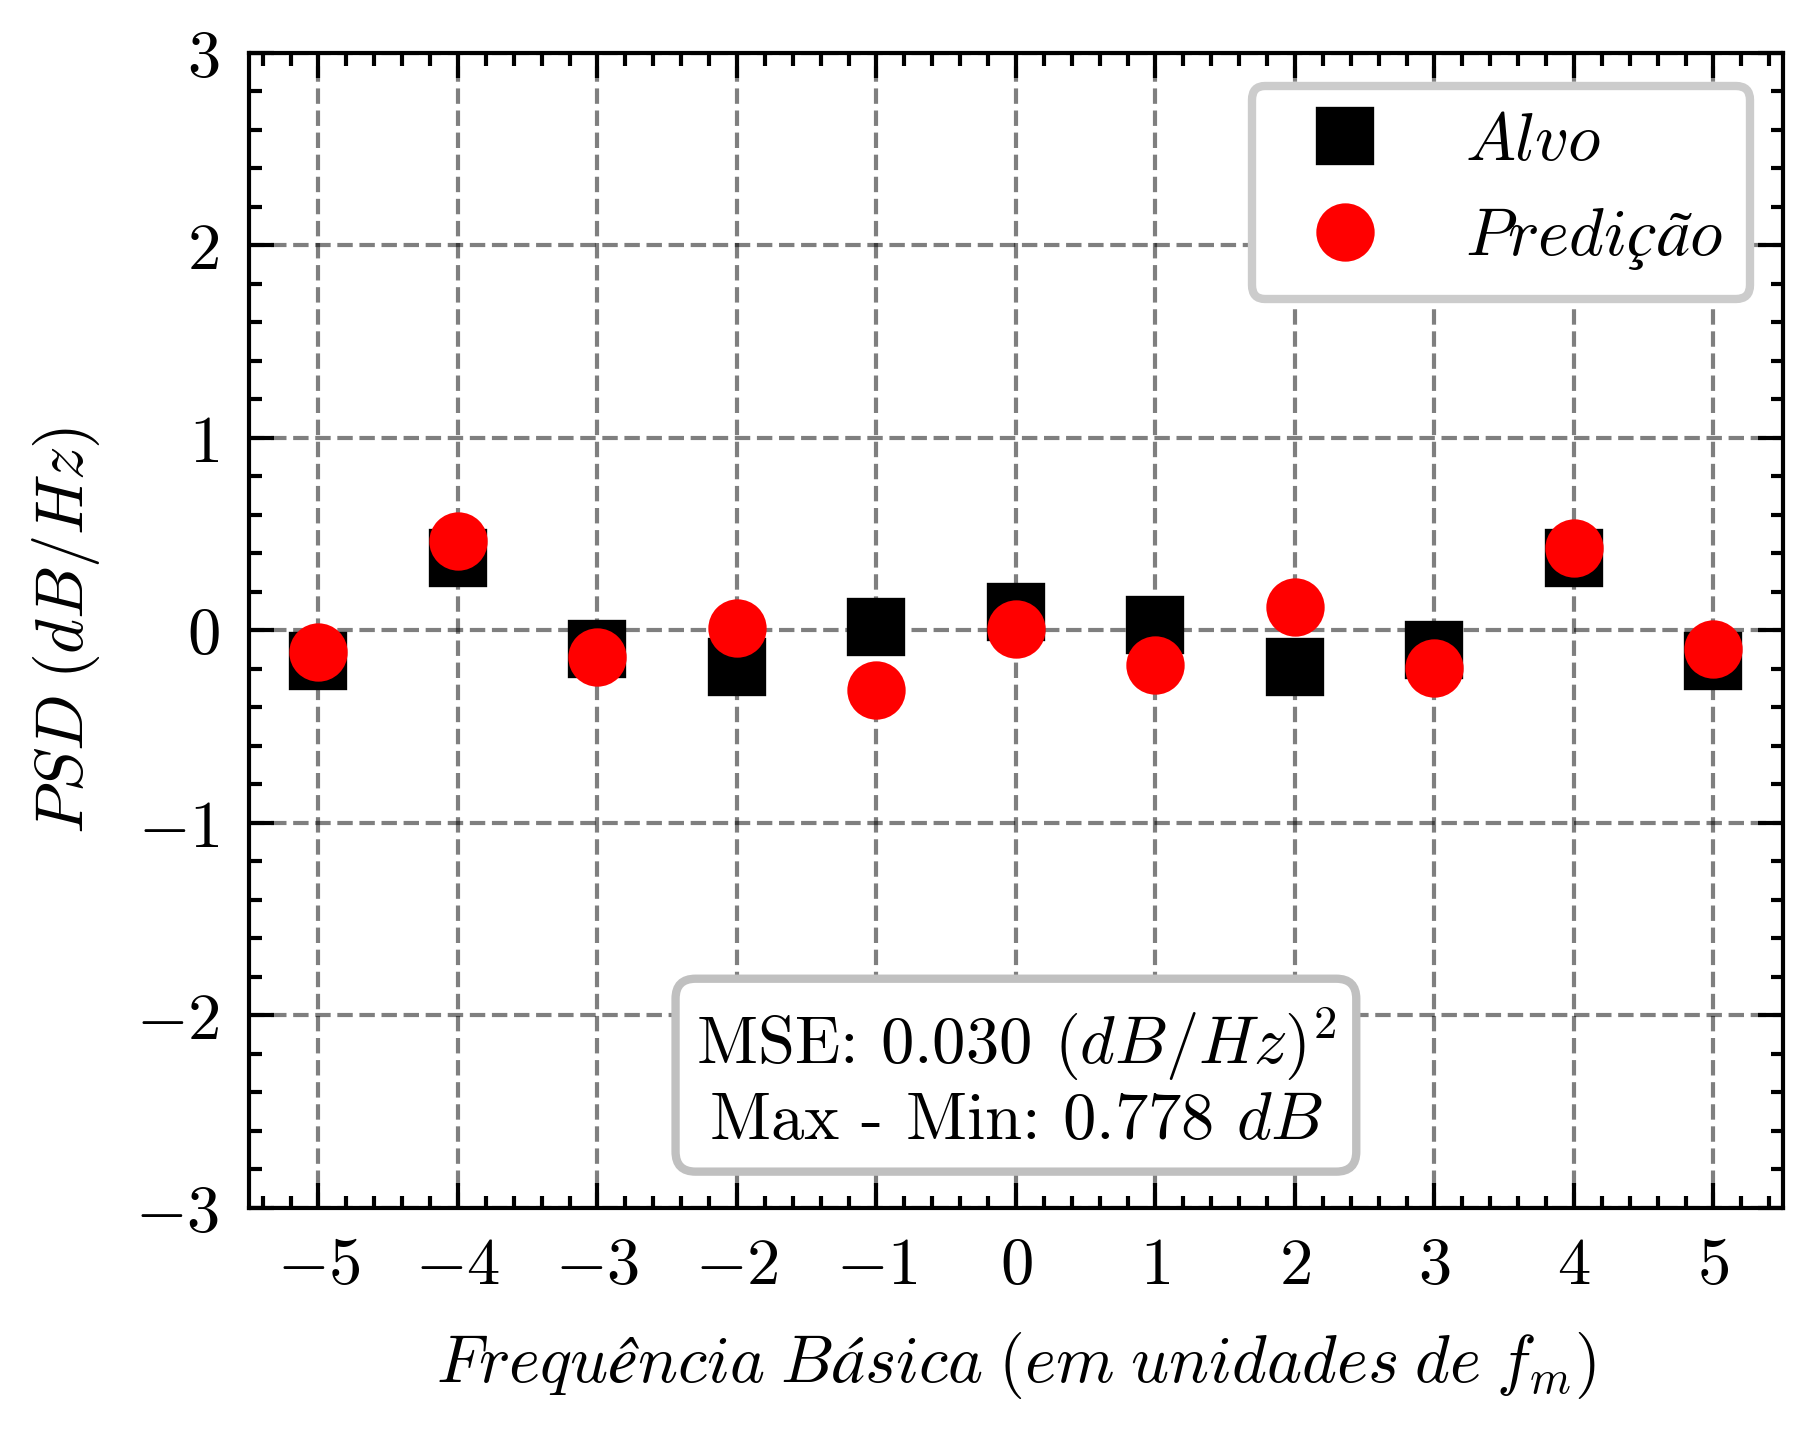

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


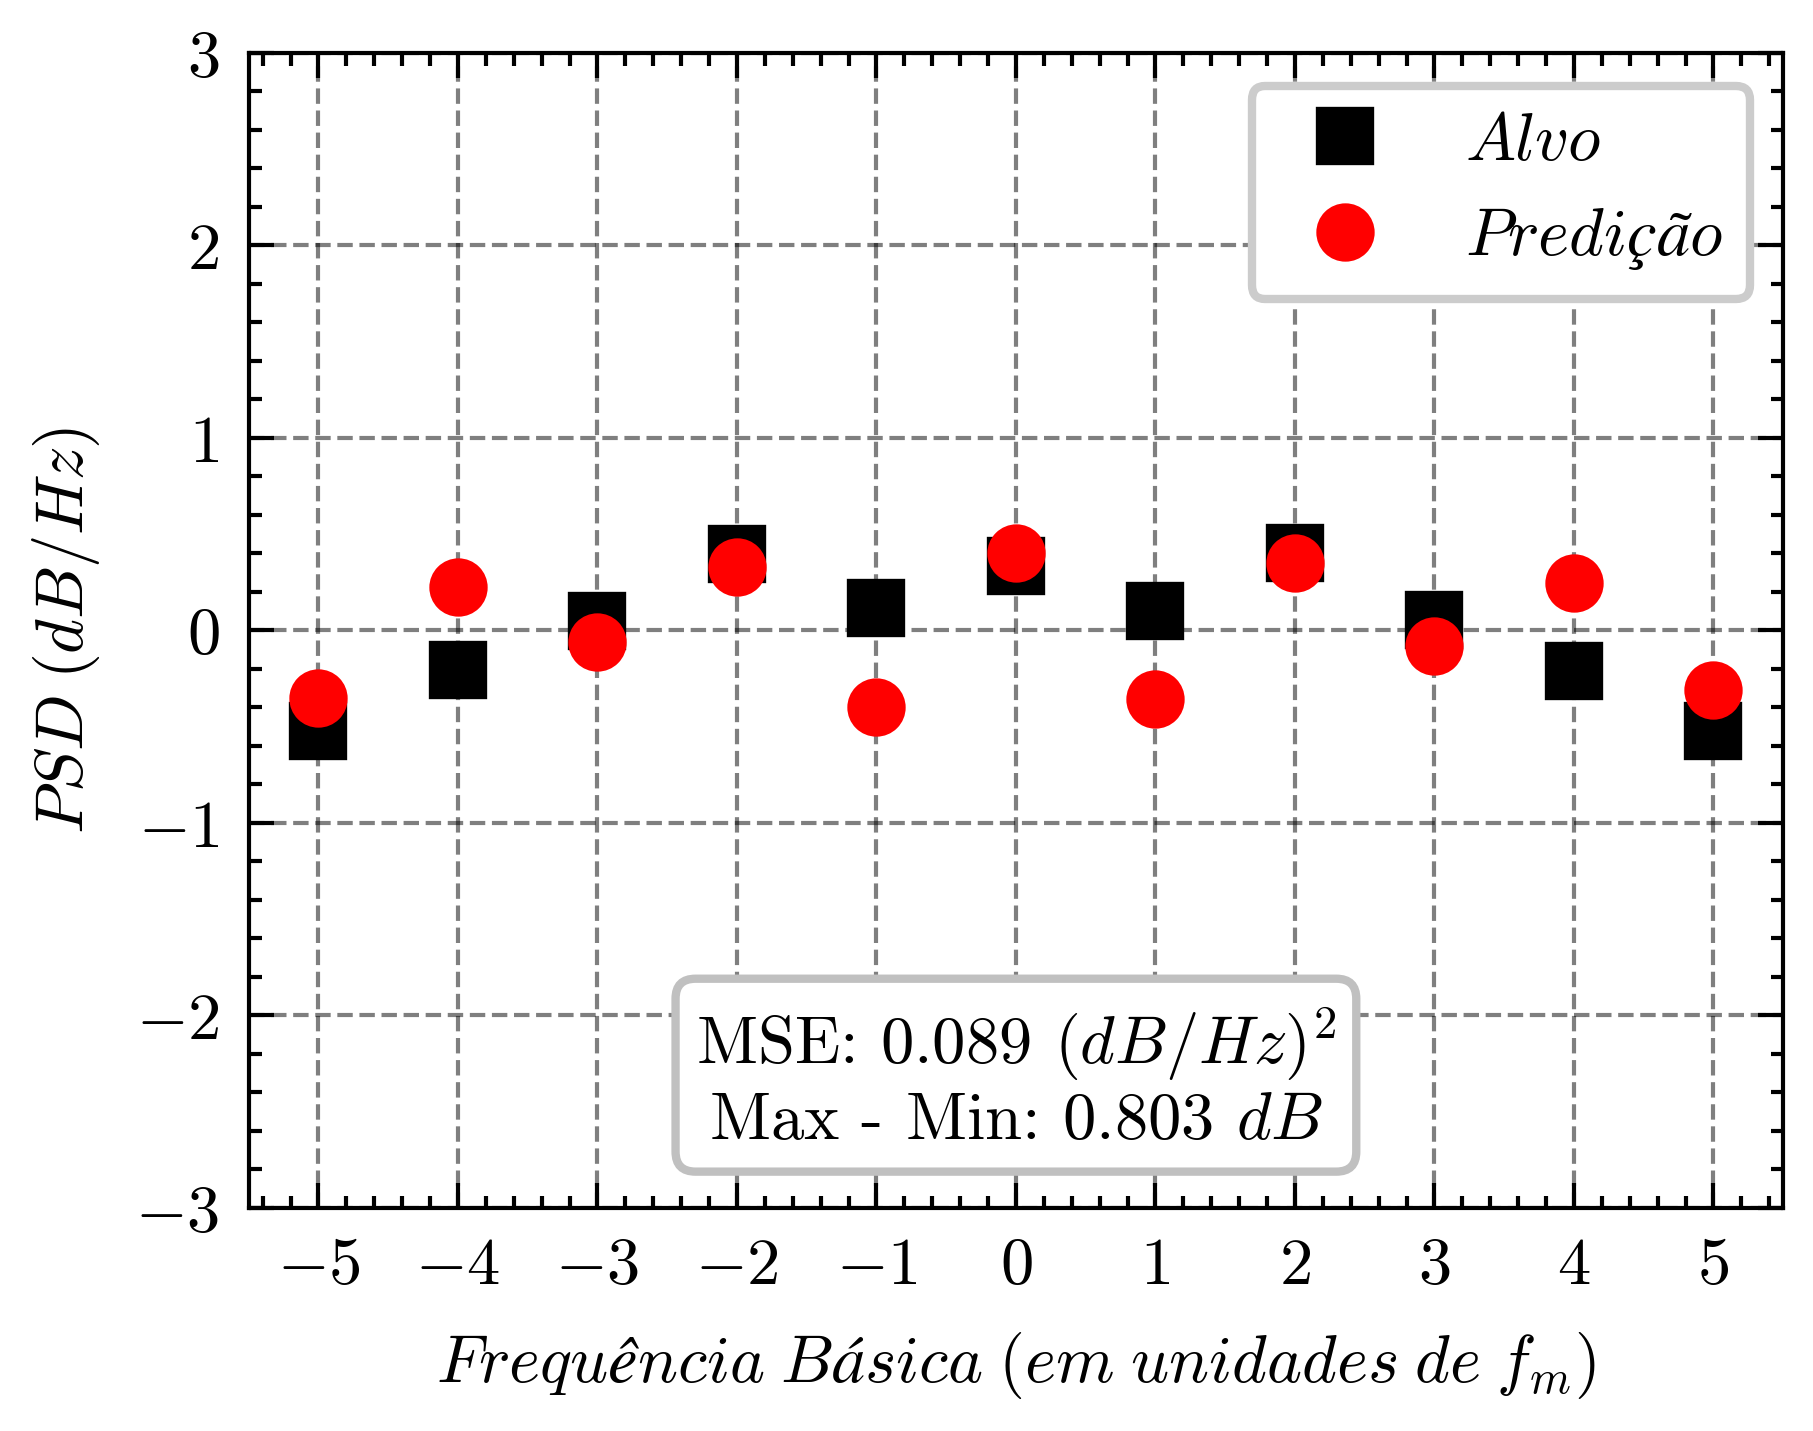

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


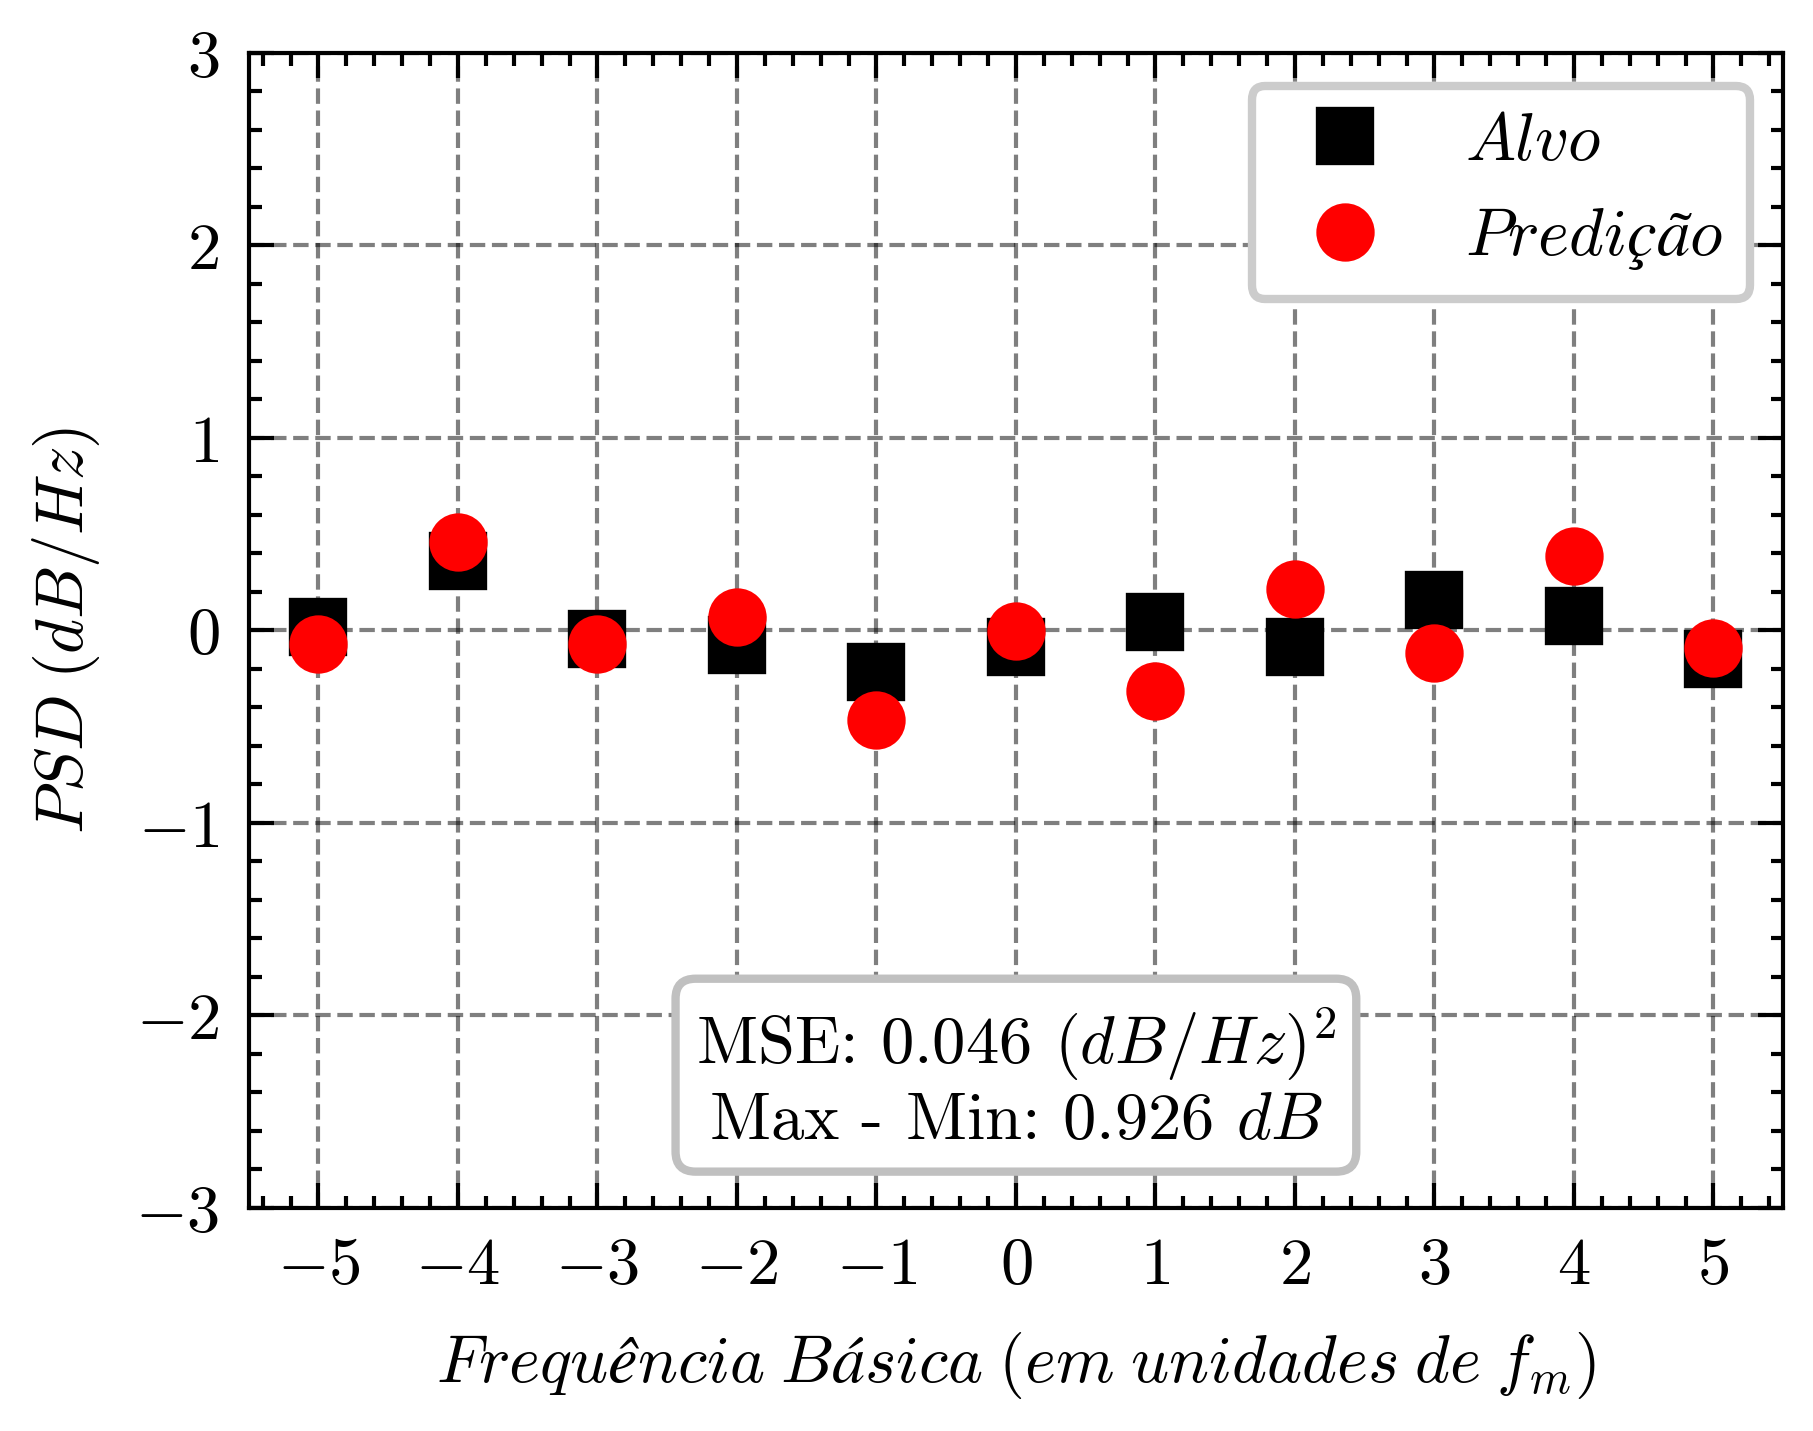

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


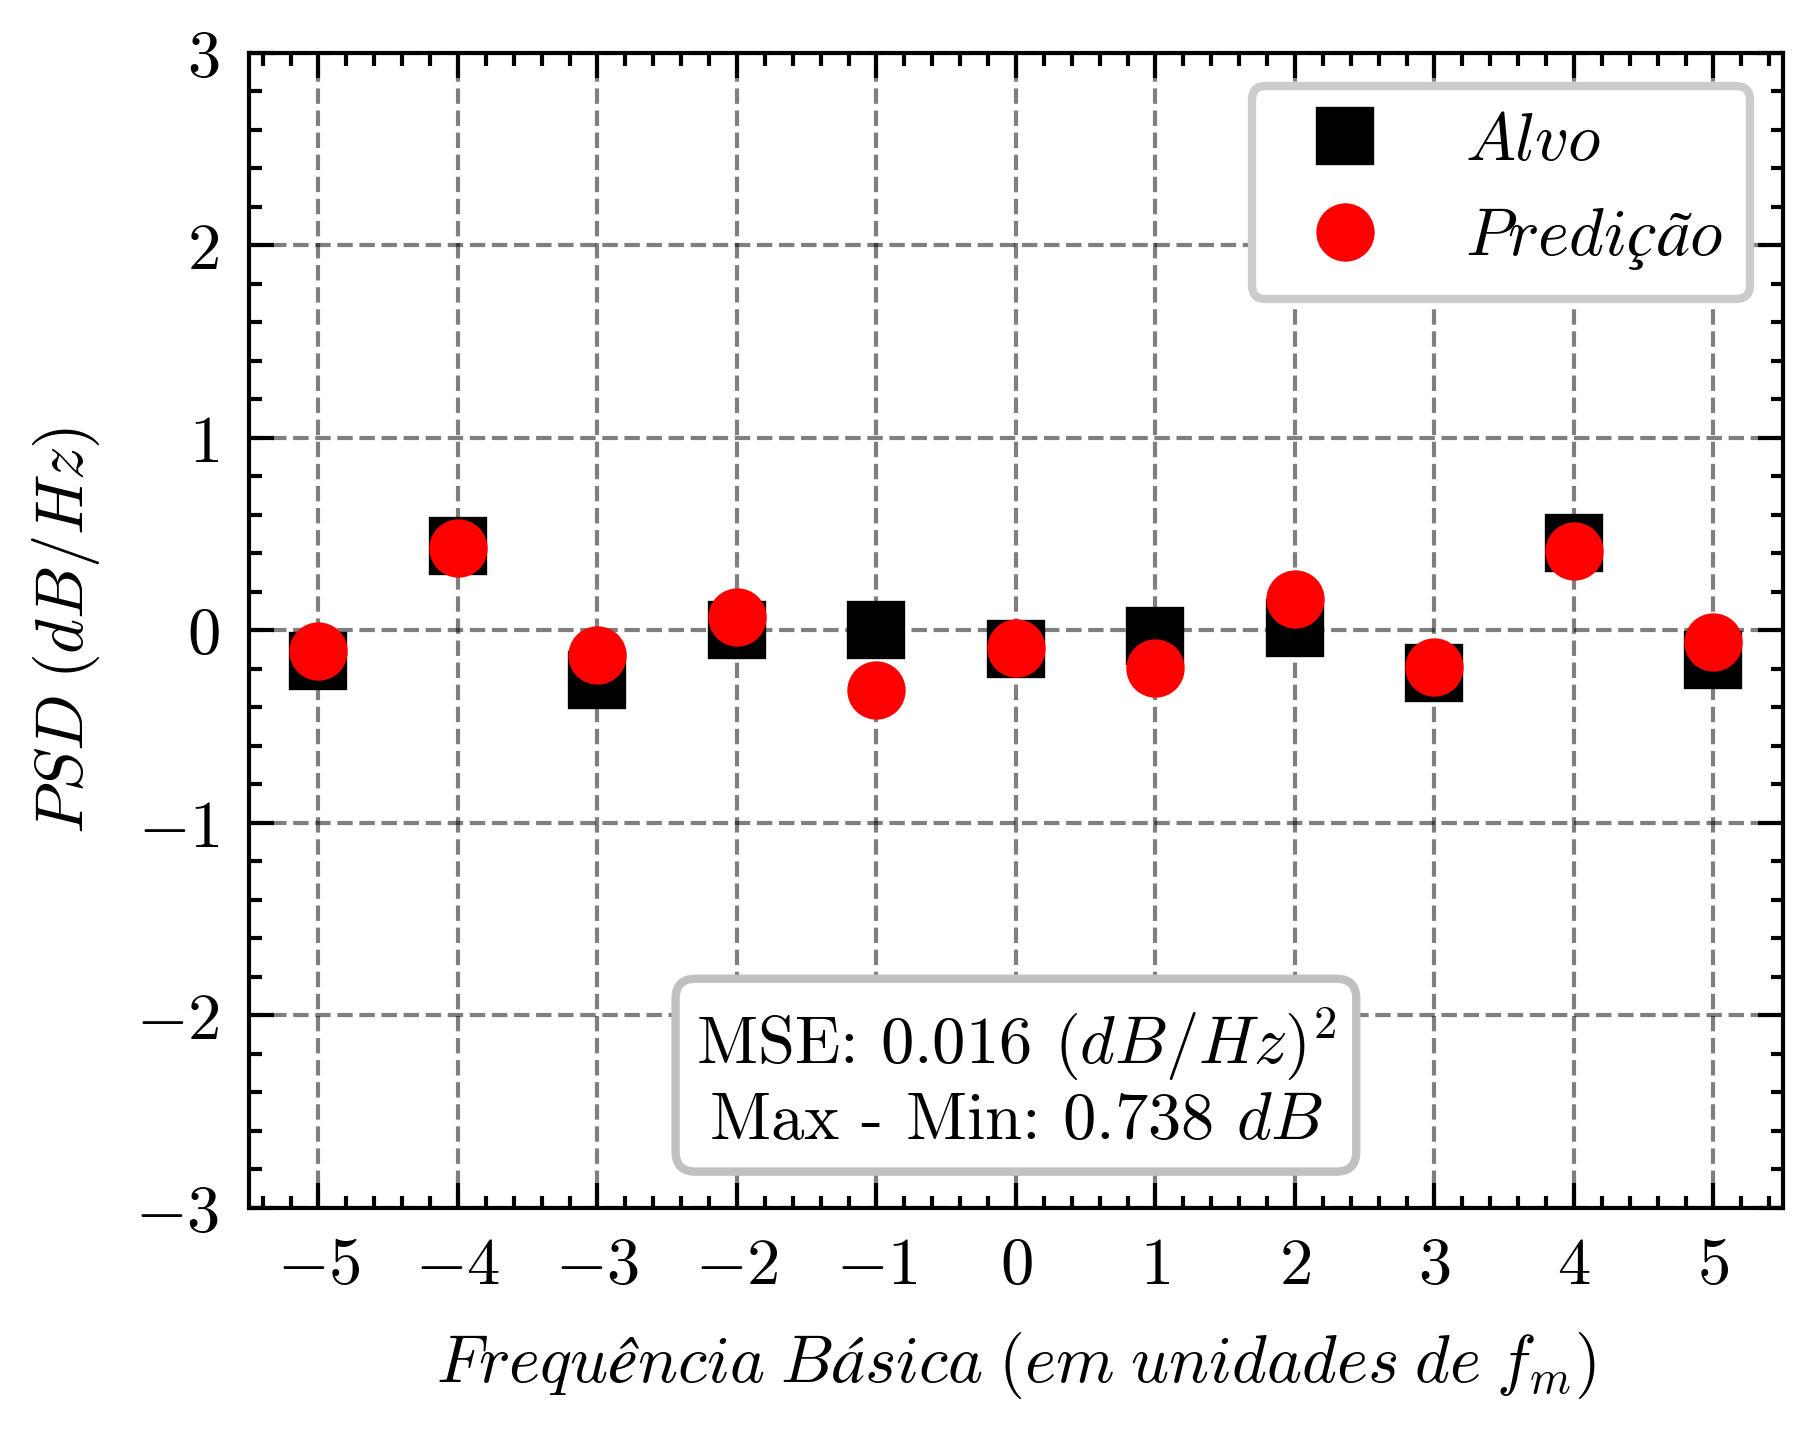

In [26]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse_PINN("test", flat_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(5, targets.shape[0])):

    inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0), ofc_args)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks) * train_loader.dataset.zero_mean
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    title = ''
    figname = "figures/inv_analitical/" + f"inv_analitical_flat_sample_{i+1}.png"
    
    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title, show_max_min=True, ylim = (-3,3))


Test Loss: 2.993777 (dB/Hz)^2


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


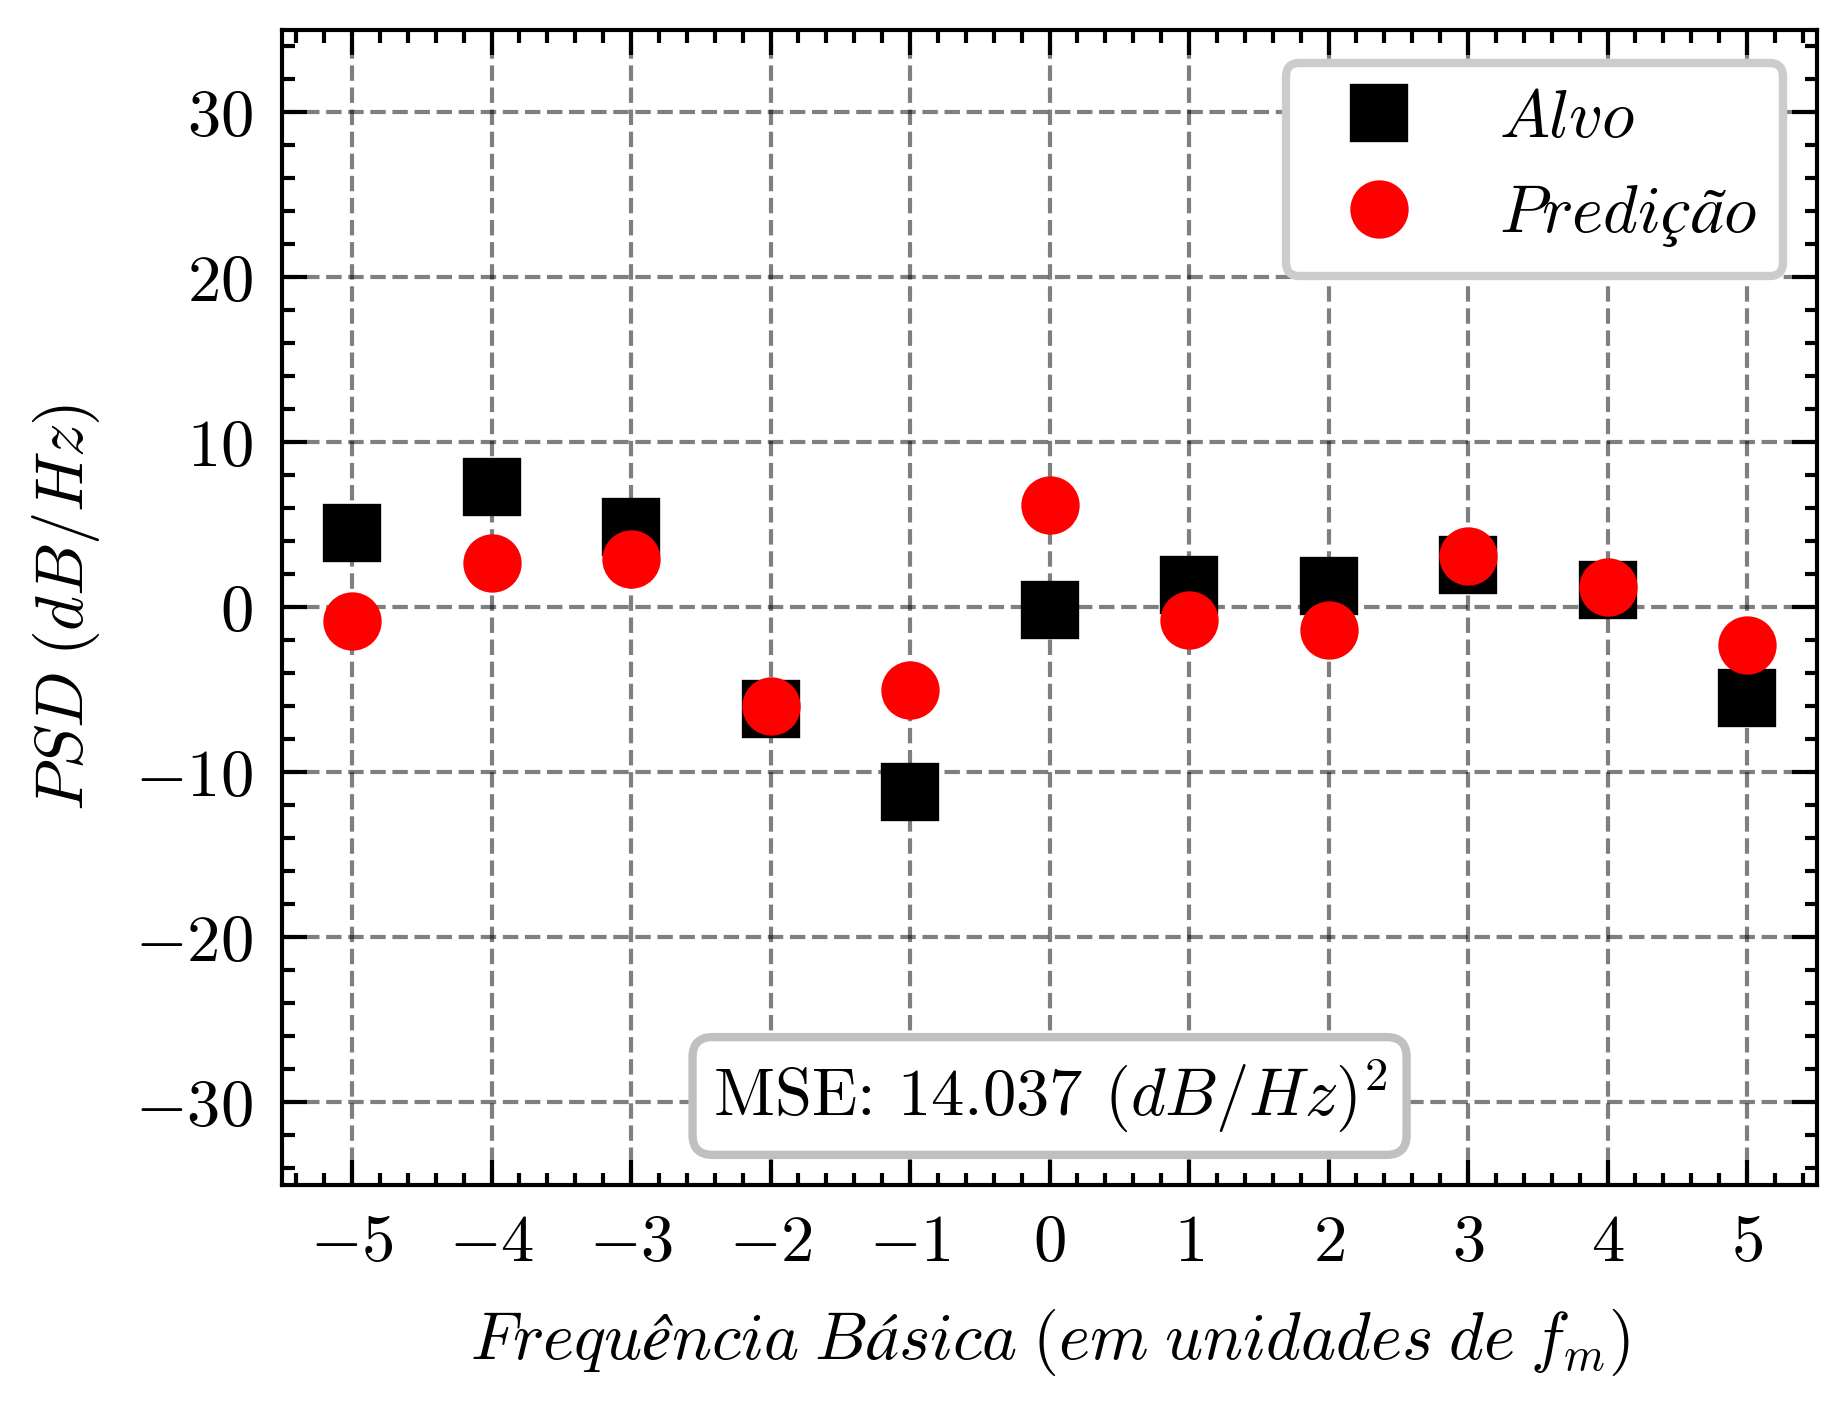

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


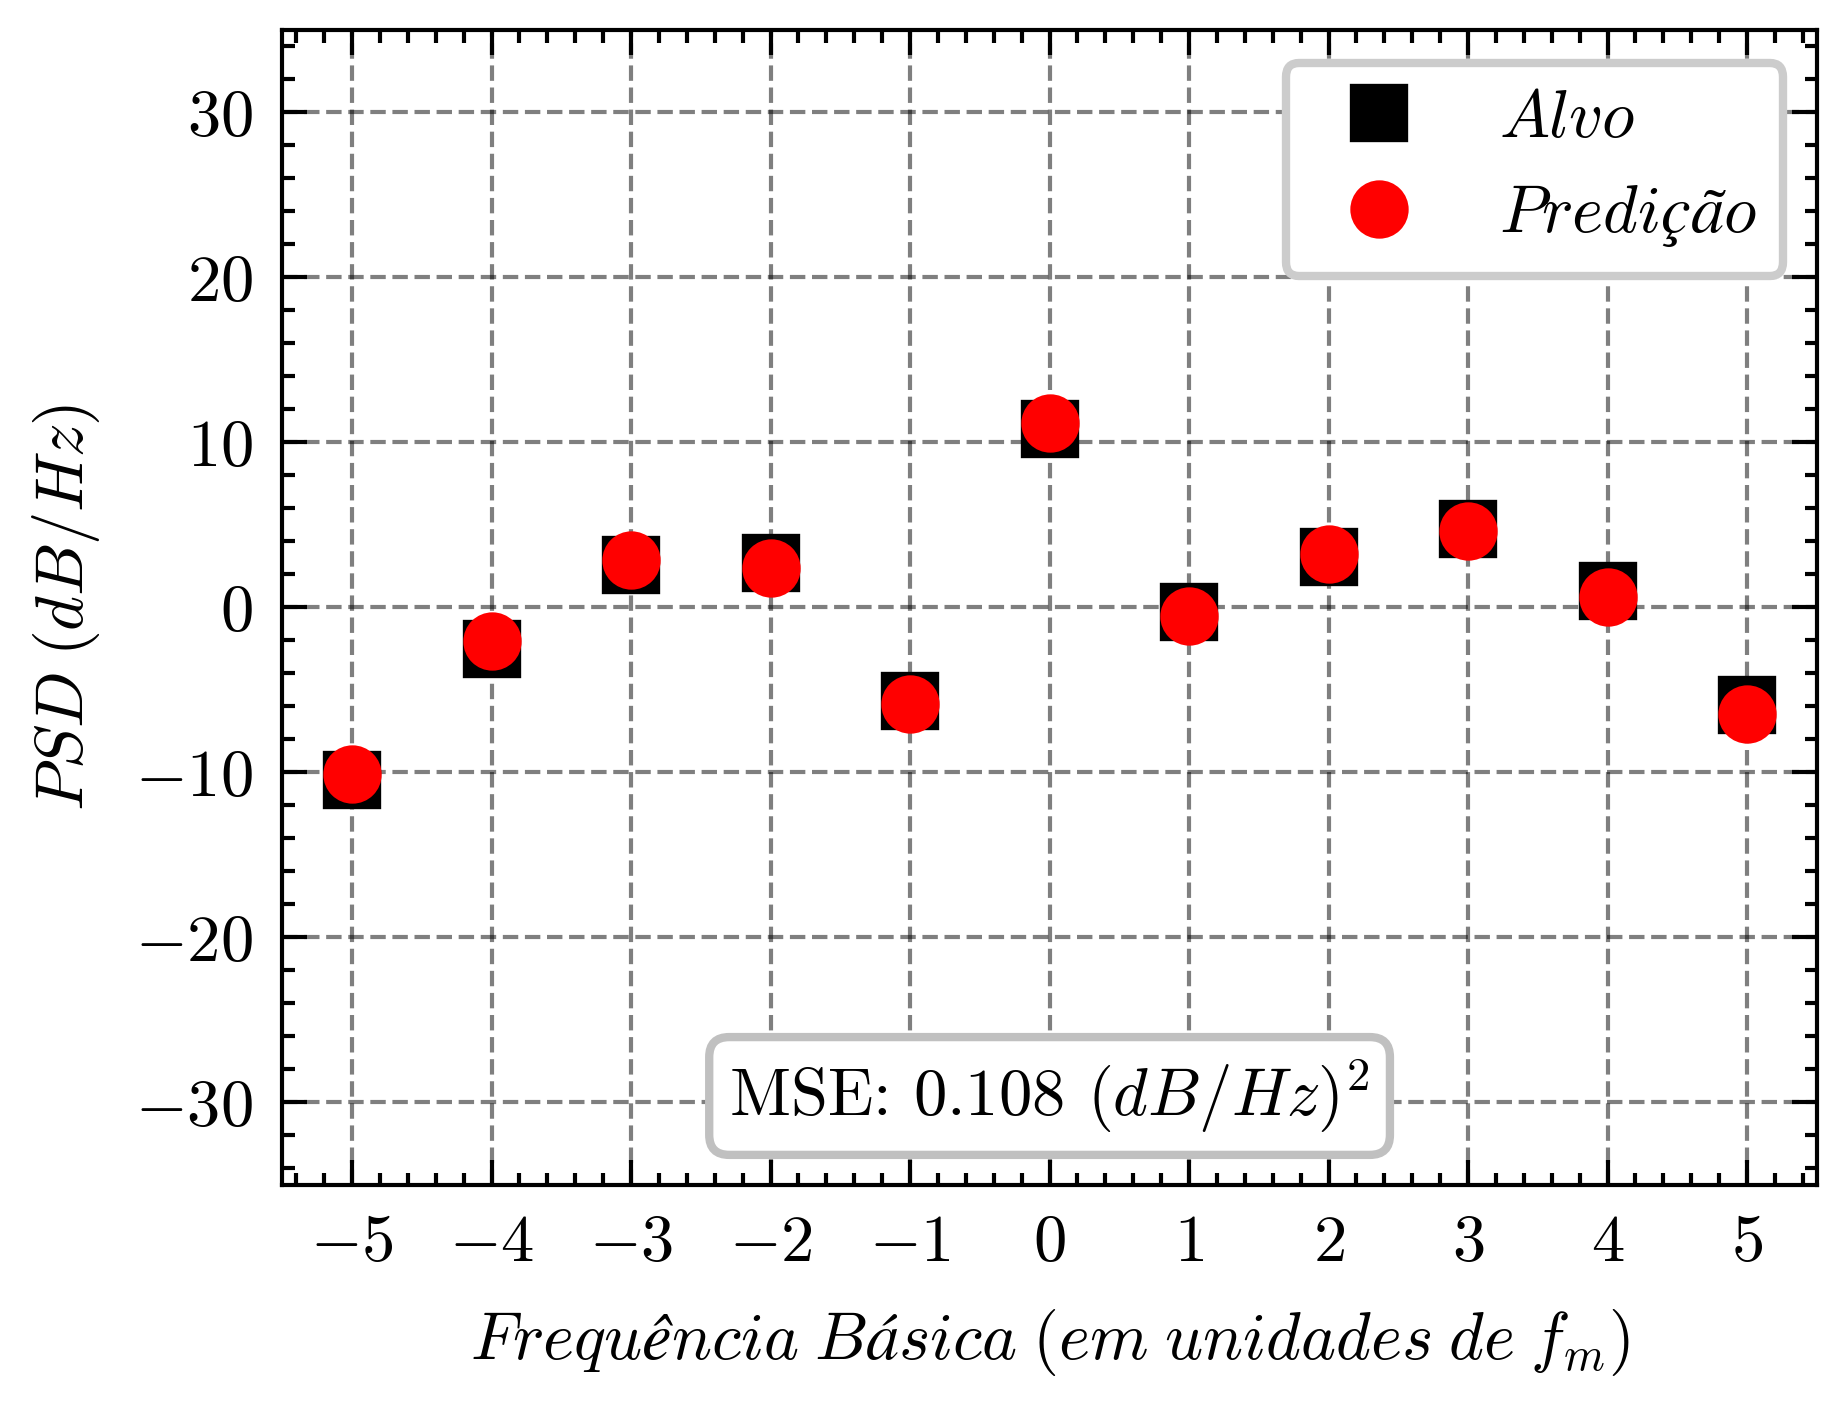

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


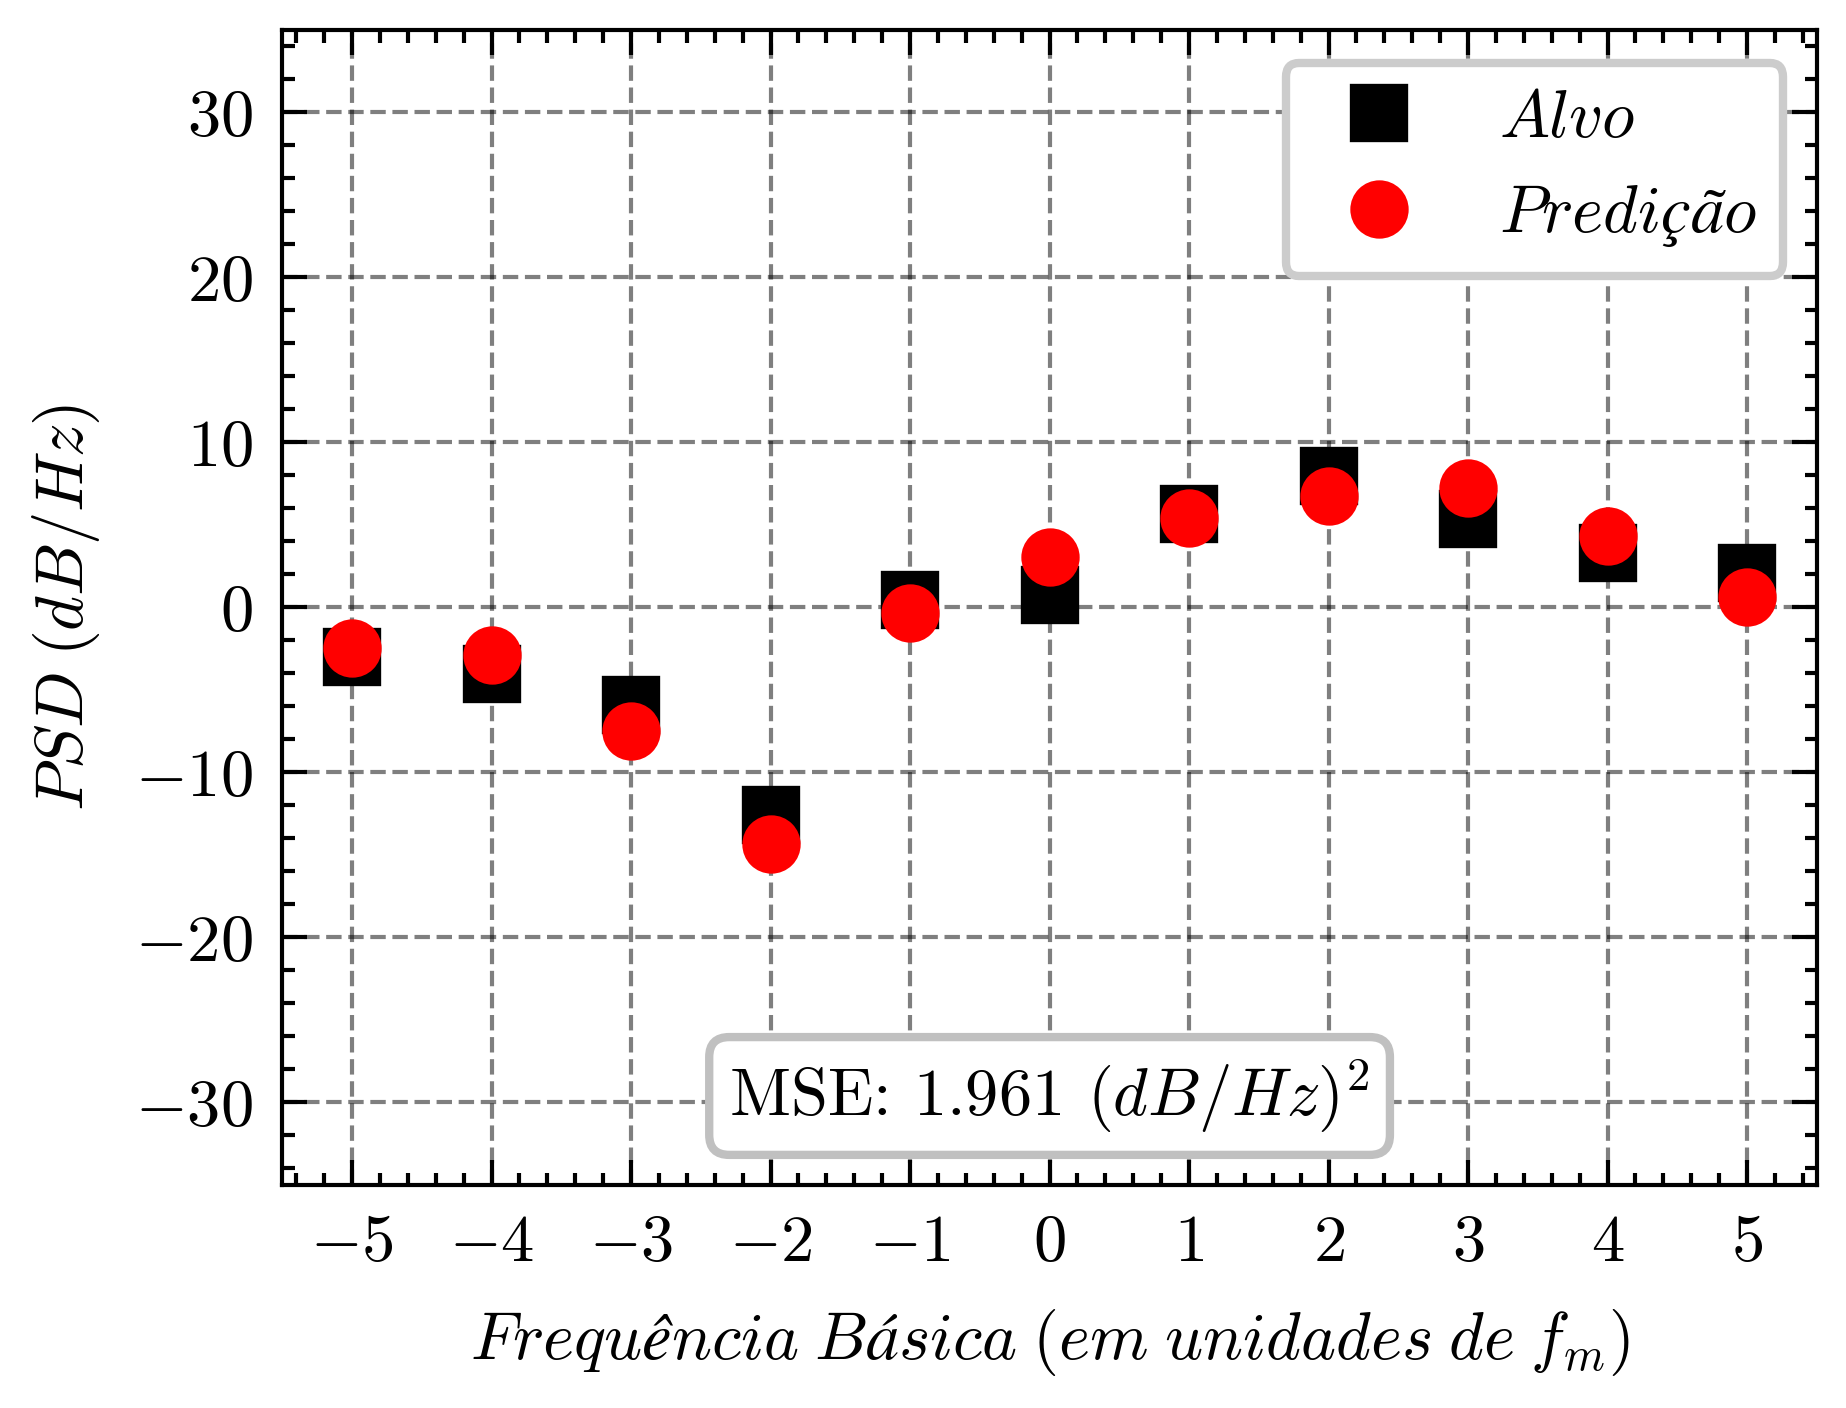

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


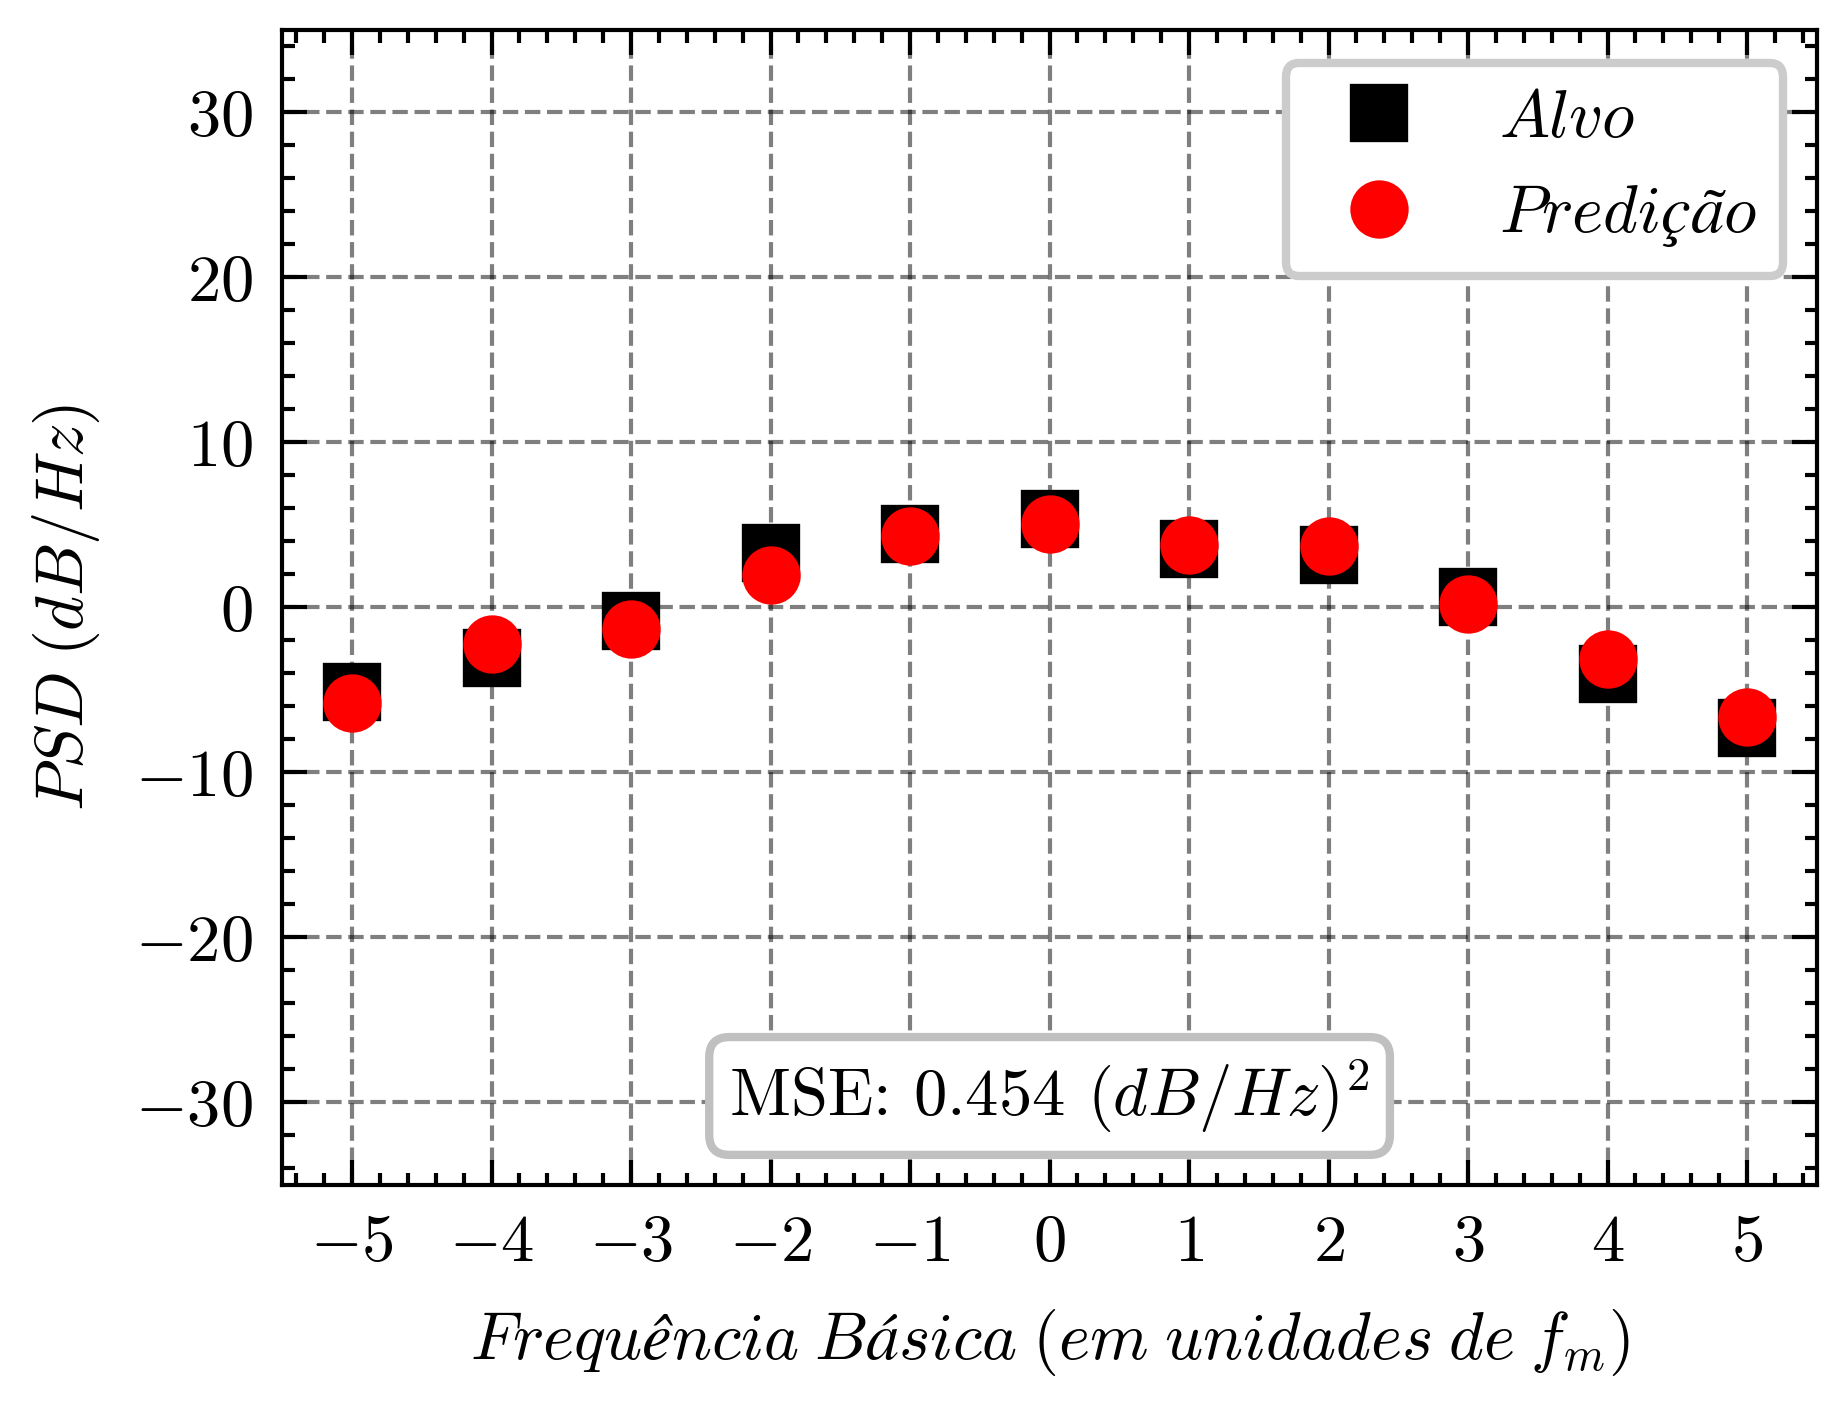

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


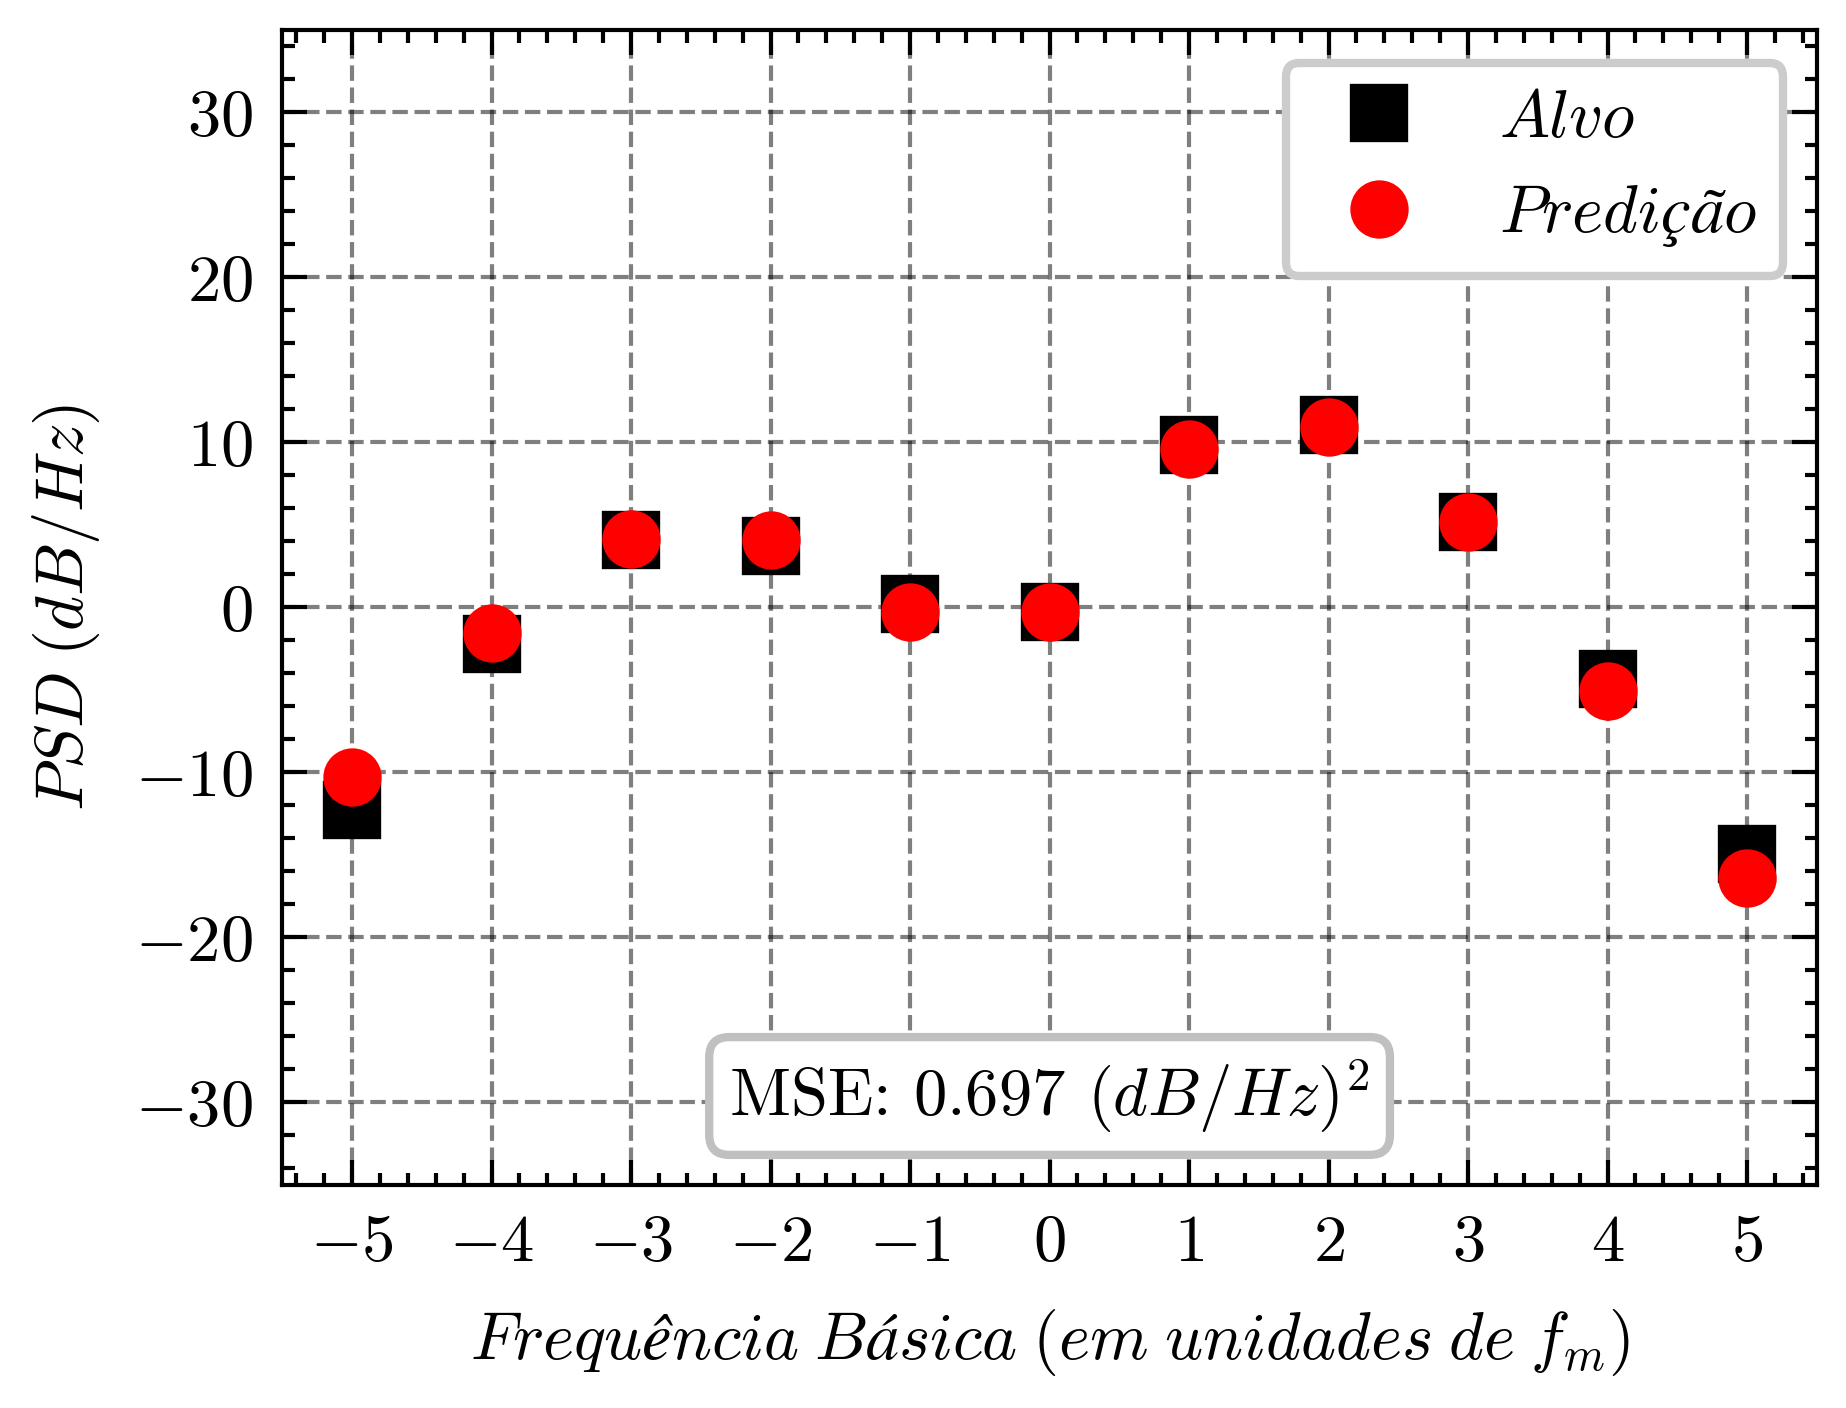

In [27]:

# Test phase
avg_test_loss, inv_for_outputs, inverse_outputs, targets, inputs = run_one_epoch_inverse_PINN("test", test_loader, frequencyCombPeaks, ofc_args, inverse_net, criterion, device)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scales):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(5, targets.shape[0])):

    inverse_peaks = frequencyCombPeaks(inverse_outputs[i].unsqueeze(0), ofc_args)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks) * train_loader.dataset.zero_mean
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    # Denormalize
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    targets_denorm = targets_denorm.cpu().detach().numpy().squeeze()
    inverse_peaks_denorm = inverse_peaks_denorm.cpu().detach().numpy().squeeze()
    title = ''
    figname = "figures/inv_analitical/" + f"inv_analitical_sample_{i+1}.png"
    
    plot_comparison_style(targets_denorm, inverse_peaks_denorm, freqs_peaks_GHz, inverse_loss, figname, title)

# <a id='toc3_'></a>[Bayesian Optimization](#toc0_)

In [12]:
from bayes_opt import BayesianOptimization
import pickle

#https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_08_4_bayesian_hyperparameter_opt.ipynb

## <a id='toc3_1_'></a>[Forward Network](#toc0_)

In [ ]:
PATIENCE = 10
NUM_EPOCHS = 100
epoch_min = 15

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

def evaluate_forward_network(learning_rate:float = 0.001 , n_layers:int = 3, n_neurons_per_layer:int = 300 , batch_size_p:float = 8):

    n_neurons_per_layer = round(n_neurons_per_layer)
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)
    architecture = [n_inputs] + [n_neurons_per_layer]*n_layers + [n_outputs]
    
    model = FrequencyCombNet(architecture).to(device)
    criterion = nn.MSELoss() # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):

        # Training phase
        run_one_epoch_forward("train", train_loader, model, criterion, device, optimizer)
        train_losses.append(avg_train_loss) #Epoch training losses for plotting

        # Validation phase
        avg_val_loss, _, _ = run_one_epoch_forward("val", val_loader, model, criterion, device)
        val_losses.append(avg_val_loss) # Append average validation loss for the epoch

        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -val_loss_min

In [ ]:
# Bounded region of parameter space
pbounds = {'learning_rate': (0.0, 0.1),
           'n_layers': (1, 7),
           'n_neurons_per_layer': (128, 512),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_forward = BayesianOptimization(
    f=evaluate_forward_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [ ]:
bayesian_optimizer_forward.maximize(init_points=10, n_iter=20)

In [ ]:
best_case = bayesian_optimizer_forward.max["params"]
best_case

In [ ]:
print("Batch_size: ", round(2**best_case["batch_size_p"]))
print("Learning Rate: ", best_case["learning_rate"])
print("Architecture: ", [n_outputs] + [round(best_case["n_neurons_per_layer"])]*round(best_case["n_layers"]) + [n_inputs])

## <a id='toc3_2_'></a>[Inverse Network](#toc0_)

In [ ]:
PATIENCE = 10
NUM_EPOCHS = 100
epoch_min = 15

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

forward_net_name = 'model_8_243_243_243_243_243_243_11_mzm_mzm_pm_300k_samples_batch_size_1024'
forward_net_path = "saved_data/models/" + forward_net_name + ".pth"
model_dict_data = torch.load(forward_net_path, map_location=torch.device(device))
forward_architecture = get_architecture(model_dict_data)
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(model_dict_data["model_state_dict"])  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

def evaluate_inverse_network(learning_rate:float = 0.001 , n_layers:int = 3, n_neurons_per_layer:int = 300 , batch_size_p:float = 8):

    n_neurons_per_layer = round(n_neurons_per_layer)
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)

    # Create an inverse model
    inverse_architecture = [n_outputs] + [n_neurons_per_layer]*n_layers + [n_inputs]
    inverse_net = FrequencyCombNet(inverse_architecture).to(device)
    
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error

    # Optimizer
    inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
            
        # Training phase
        run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)

        # Validation phase
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
        
        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -avg_val_loss

def evaluate_inverse_network2(learning_rate:float = 0.0001 , n_layers:int = 6, batch_size_p:float = 6.5):

    N = 600000 # Quantity of net parameters

    #n_layers should be > 1
    a = (n_layers-1)
    b = (n_layers+n_inputs+n_outputs)
    c = (n_outputs-N)
    n_neurons_per_layer = round((-b + np.sqrt(b**2 - 4*a*c))/(2*a))
    
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)

    # Create an inverse model
    inverse_architecture = [n_outputs] + [n_neurons_per_layer]*n_layers + [n_inputs]
    inverse_net = FrequencyCombNet(inverse_architecture).to(device)
    
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error

    # Optimizer
    inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
            
        # Training phase
        run_one_epoch_inverse("train", train_loader, forward_net, inverse_net, criterion, device, inv_optimizer)

        # Validation phase
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse("val", val_loader, forward_net, inverse_net, criterion, device)
        
        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    return -avg_val_loss



In [ ]:
# Bounded region of parameter space
pbounds = {'learning_rate': (0.0, 0.0001),
           'n_layers': (3, 6),
           'n_neurons_per_layer': (128, 512),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_inverse = BayesianOptimization(
    f=evaluate_inverse_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)


#with open('bayes_opt_state_inv.pkl', 'rb') as f:
#    bayesian_optimizer_inverse = pickle.load(f)

In [ ]:
bayesian_optimizer_inverse.maximize(init_points=0, n_iter=20)

In [ ]:
# Bounded region of parameter space
pbounds2 = {'learning_rate': (0.0, 0.0001),
           'n_layers': (3, 6),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_inverse = BayesianOptimization(
    f=evaluate_inverse_network2,
    pbounds=pbounds2,
    verbose=2,
    random_state=1,
)

In [ ]:
bayesian_optimizer_inverse.maximize(init_points=10, n_iter=20)

In [ ]:
import pandas as pd

bayesian_optimizer_inverse_res = [{"target": i["target"], **i["params"]} for i in bayesian_optimizer_inverse.res]
bayesian_optimizer_inverse_res = [{"target": i["target"], "batch_size": round(2**i["batch_size_p"]), "learning_rate": i["learning_rate"], "n_layers": round(i["n_layers"]), "n_neurons_per_layer": round(i["n_neurons_per_layer"])} for i in bayesian_optimizer_inverse_res]

# Convert the optimization history to a DataFrame
optimization_history = pd.DataFrame(bayesian_optimizer_inverse_res).sort_values(by='target', ascending=False)
display(optimization_history.head(30))

In [ ]:
#save optimizer state checkout to load and continue the optimization later
with open('bayes_opt_state_inv2.pkl', 'wb') as f:
    pickle.dump(bayesian_optimizer_inverse, f)

In [ ]:
best_case = bayesian_optimizer_inverse.max["params"]
print("Batch_size: ", round(2**best_case["batch_size_p"]))
print("Learning Rate: ", best_case["learning_rate"])
print("Architecture: ", [n_outputs] + [round(best_case["n_neurons_per_layer"])]*round(best_case["n_layers"]) + [n_inputs])

## <a id='toc3_3_'></a>[Inverse Network - PINN](#toc0_)

In [13]:
PATIENCE = 50
NUM_EPOCHS = 200
epoch_min = 15

n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]

def evaluate_inverse_network_PINN(learning_rate:float = 0.001 , n_layers:int = 3, n_neurons_per_layer:int = 300 , batch_size_p:float = 8):

    n_neurons_per_layer = round(n_neurons_per_layer)
    n_layers = round(n_layers)
    batch_size = round(2**batch_size_p)

    # Create an inverse model
    inverse_architecture = [n_outputs] + [n_neurons_per_layer]*n_layers + [n_inputs]
    inverse_net = FrequencyCombNet(inverse_architecture).to(device)
    
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error

    # Optimizer
    inv_optimizer = torch.optim.Adam(inverse_net.parameters(), lr = learning_rate) # lr - learning rate

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

    val_loss_min = 1
    patience_counter = 0

    for epoch in range(1, NUM_EPOCHS + 1):
            
        # Training phase
        run_one_epoch_inverse_PINN("train", train_loader, analytical_function_compact, ofc_args, inverse_net, criterion, device, inv_optimizer)

        # Validation phase
        avg_val_loss, _, _, _, _ = run_one_epoch_inverse_PINN("val", val_loader, analytical_function_compact, ofc_args, inverse_net, criterion, device)
                
        # Patience counter
        if avg_val_loss <= val_loss_min:
            val_loss_min = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE and epoch > epoch_min:
            break

    print(inverse_architecture, f"n_epochs: {epoch}")

    #return -avg_val_loss
    return -val_loss_min

In [14]:
# Bounded region of parameter space
pbounds = {'learning_rate': (0.0, 0.0001),
           'n_layers': (3, 8),
           'n_neurons_per_layer': (128, 512),
           'batch_size_p': (6, 10)
           }

bayesian_optimizer_inverse_PINN = BayesianOptimization(
    f=evaluate_inverse_network_PINN,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)


#with open('bayes_opt_state_inv_pinn.pkl', 'rb') as f:
#    bayesian_optimizer_inverse_PINN = pickle.load(f)

In [15]:
bayesian_optimizer_inverse_PINN.maximize(init_points=10, n_iter=20)

|   iter    |  target   | batch_... | learni... | n_layers  | n_neur... |
-------------------------------------------------------------------------
[11, 244, 244, 244, 8] n_epochs: 200
| 1         | -0.000229 | 7.668     | 7.203e-05 | 3.001     | 244.1     |
[11, 261, 261, 261, 261, 8] n_epochs: 200
| 2         | -0.000269 | 6.587     | 9.234e-06 | 3.931     | 260.7     |
[11, 391, 391, 391, 391, 391, 8] n_epochs: 137
| 3         | -0.000259 | 7.587     | 5.388e-05 | 5.096     | 391.1     |
[11, 385, 385, 385, 8] n_epochs: 128
| 4         | -0.000215 | 6.818     | 8.781e-05 | 3.137     | 385.5     |
[11, 204, 204, 204, 204, 8] n_epochs: 200
| 5         | -0.000219 | 7.669     | 5.587e-05 | 3.702     | 204.1     |
[11, 394, 394, 394, 394, 394, 8] n_epochs: 146
| 6         | -0.000254 | 9.203     | 9.683e-05 | 4.567     | 393.9     |
[11, 143, 143, 143, 8] n_epochs: 200
| 7         | -0.000267 | 9.506     | 8.946e-05 | 3.425     | 143.0     |
[11, 290, 290, 290, 8] n_epochs: 200
| 8     

In [16]:
import pandas as pd

bayesian_optimizer_inverse_res = [{"target": i["target"], **i["params"]} for i in bayesian_optimizer_inverse_PINN.res]
bayesian_optimizer_inverse_res = [{"target": i["target"], "batch_size": round(2**i["batch_size_p"]), "learning_rate": i["learning_rate"], "n_layers": round(i["n_layers"]), "n_neurons_per_layer": round(i["n_neurons_per_layer"])} for i in bayesian_optimizer_inverse_res]

# Convert the optimization history to a DataFrame
optimization_history = pd.DataFrame(bayesian_optimizer_inverse_res).sort_values(by='target', ascending=False)

In [17]:
display(optimization_history.head(30))

,target,batch_size,learning_rate,n_layers,n_neurons_per_layer
24,-0.000120,90,0.000098,8,392
16,-0.000136,251,0.000088,8,342
14,-0.000168,105,0.000065,4,290
7,-0.000175,102,0.000088,3,290
12,-0.000195,66,0.000024,4,289
27,-0.000200,134,0.000050,4,341
17,-0.000212,323,0.000052,7,239
3,-0.000215,113,0.000088,3,385
10,-0.000219,426,0.000046,4,289
4,-0.000220,204,0.000056,4,204


In [23]:
display(optimization_history.head(30))

,target,batch_size,learning_rate,n_layers,n_neurons_per_layer
27,-0.000099,65,0.000081,7,298
20,-0.000115,74,0.000070,7,293
21,-0.000120,76,0.000040,8,296
22,-0.000123,80,0.000071,6,299
24,-0.000127,70,0.000071,6,296
16,-0.000152,110,0.000043,6,292
12,-0.000153,447,0.000094,6,395
19,-0.000166,87,0.000041,7,291
17,-0.000187,85,0.000070,4,294
5,-0.000194,589,0.000097,5,394


In [24]:
# save with pickle optimization state
with open('bayes_opt_state_inv_pinn.pkl', 'wb') as f:
    pickle.dump(bayesian_optimizer_inverse_PINN, f)

In [ ]:
display(optimization_history.head(30))

# <a id='toc4_'></a>[Other Auxiliar Figures](#toc0_)

In [ ]:
#plotting the first four Bessel funcions
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import jn


with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize=(3*0.8,2.4*0.8), dpi = 300)
    x = np.linspace(0, 20, 100)
    for n in range(4):
        plt.plot(x, jn(n, x), label=fr"$J_{n}(x)$", color = f"C{n}",lw =1.2)

    ax.legend()
    ax.autoscale(tight=True)
    ax.set_xlabel("$x$")
    ax.set_ylabel(r"$J_n(x)$")
    ax.set_xlim(0, 17)
    ax.set_ylim(-0.5,1.3)
    ax.set_yticks(np.arange(-0.4,1.4,0.4))
    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
    fig.savefig("bessel_Jn", dpi=300)
    plt.show()
    plt.close()

In [ ]:
#plotting the power spectral density of a optical frequency comb generated using PM modulation

V1 = 10
Phase1 = 0
u1 = V1 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase1)
frequency_comb = pm(1, u1, 5)
#'''
params = [2,2,2,2,2,4,3,3]
params = [2,2,2,4,3,4,3,3]
V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2 = params

u1 = V1 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase1)
u2 = V2 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase2)
u3 = V3 * np.cos(2 * π * ofc_args.Rs * ofc_args.t + Phase3)

frequency_comb = ofc_args.P
frequency_comb =  pm(frequency_comb, u3, ofc_args.Vpi)
frequency_comb = mzm(frequency_comb, u1, ofc_args.Vpi, Vb1)
frequency_comb = mzm(frequency_comb, u2, ofc_args.Vpi, Vb2)
#'''

Pxx, freqs = get_psd_ByFFT(frequency_comb, ofc_args.Fa, ofc_args.NFFT) # Get the power spectrum of the frequency comb signal
log_Pxx = 10*np.log10(Pxx) # Convert the power spectrum to dB
indx = get_indx_peaks(log_Pxx, ofc_args.NFFT/ofc_args.SpS, ofc_args.n_peaks) 
peaks = log_Pxx[indx].tolist()
   
with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    ax.plot(freqs/ofc_args.Rs,log_Pxx,"g-", label='Optical Frequency Comb',lw = 1.3)
    ax.plot(freqs[indx]/ofc_args.Rs,peaks,"ko", label='Peaks', markersize=4)
    ax.autoscale(tight=True)
    
    ax.set_xlim(-10.9, 10.9)
    ax.set_ylim(-126, -82)
    #ax.set_ylim(-300, -82)
    ax.set_xlabel(r"$Frequência\; Básica\; (em\; unidades\; de\; f_m)$")
    ax.set_ylabel(r"$PSD\; (dB/Hz)$")

    #ax.yaxis.tick_right()
    #ax.yaxis.set_label_position("right")

    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

    #fig.savefig("ofc_pm_example", dpi=300)
    fig.savefig("ofc_peaks_example", dpi=300)
    plt.show()
    plt.close()
    

In [ ]:
Vpi = 2
Vdc = -2

Vmax = 4
Vmin = -4
V = np.linspace(Vmin, Vmax, 100)

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize=(5*0.8,2.4*0.8), dpi = 300)
    
    ax.plot(V/Vpi, mzm(1,V, Vpi, Vdc), label = r'$Campo$')
    ax.plot(V/Vpi, np.abs(mzm(1,V, Vpi, Vdc))**2, label = r'$Potência$')
    ax.plot(0, np.abs(mzm(1,0, Vpi, Vdc))**2, 'sr', markersize=4)
    ax.plot(Vpi/Vpi, np.abs(mzm(1,Vpi, Vpi, Vdc))**2, 'or', markersize=4)
    ax.autoscale(tight=True)
    
    ax.set_xlim([Vmin/Vpi, Vmax/Vpi])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel(r'$V (V_\pi)$')
    ax.set_ylabel(r'$Transmitância (a.u.)$')
    ax.legend()

    plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
    fig.savefig("mzm_op", dpi=300)
    plt.show()
    plt.close()

In [ ]:
x

In [ ]:
# i want to plot a graph with some point around a regression line to ilustrated de MSE error

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

np.random.seed(1)
x = np.linspace(0.5, 3.5, 6)
y = 4 + 2 * x + np.random.randn(6, 1).squeeze()

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    regress = linregress(x.squeeze(), y.squeeze())

    xx = np.linspace(0,4)
    ax.plot(xx, regress.intercept + regress.slope*xx, "r--")

    sig = [1, -1, -1, -1, 1,-1]
    for i in range(x.shape[0]):
        ax.plot([x[i], x[i]], [y[i], regress.intercept + regress.slope*x[i]], "k-",lw =1)
        #colocar um traço horizontal nas pontas de cada linha de erro
        traco = 0.05
        ax.plot([x[i]-traco, x[i]+traco], [regress.intercept + regress.slope*x[i], regress.intercept + regress.slope*x[i]], "k-",lw =1)
        ax.plot([x[i]-traco, x[i]+traco], [y[i]-0.15*sig[i], y[i]-0.15*sig[i]], "k-",lw =1)

    #no penultimo ponto colocar o texto y e y_hat, centralizado, negrito r"$\textbf{y}$" e r"$\textbf{\hat{y}}$"
    ax.text(x[-2], y[-2]+0.4, r'$y_i$', fontsize=10, ha='center')
    ax.text(x[-2], regress.intercept + regress.slope*x[-2]-0.8, r'$\hat{y}_i$', fontsize=10, ha='center')

    ax.plot(x, y, "b.")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.autoscale(tight=True)
    ax.set_ylim(4, 12.5)

    



In [ ]:
yerr

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
x = np.linspace(0,5,10)
y = 1.5 * x + 4
yerr = 2*np.abs(np.random.randn(10, 1).squeeze())


upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    ax.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits)
    ax.plot(x,y, "r-", lw =2)
    ax.plot(x,y, "r-", lw =2)
    ax.show()
    ax.close()



In [ ]:
# i want to plot a graph with some point around a regression line to ilustrated de MSE error using errror bars

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

np.random.seed(1)
x = np.linspace(0.5, 3.5, 5)
y = 4 + 2 * x + np.random.randn(5, 1).squeeze()

with plt.style.context(['science', 'ieee', "grid", 'no-latex']):
    fig, ax = plt.subplots(figsize = (3*0.8,2.4*0.8), dpi = 300)
    regress = linregress(x.squeeze(), y.squeeze())
    
    xx = np.linspace(0,4)
    ax.plot(xx, regress.intercept + regress.slope*xx, "r--")
    ax.errorbar(x, y, yerr=0.2, fmt='o', color='b', ecolor='r', capsize=5)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.autoscale(tight=True)
    fig.savefig("regression_error", dpi=300)
    plt.show()
    plt.close()